# ***Integrated Retail Analytics for Store Optimization and Demand Forecasting***

### ***Import required libraries***

In [194]:
# Standard Library Imports
import os
import joblib
import warnings

# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical Analysis
import scipy.stats as stats
from scipy.stats import skew, kurtosis

# Time Series Analysis
from prophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning - Core
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, silhouette_score, homogeneity_score, completeness_score

# Machine Learning - Gradient Boosting
import xgboost as xgb
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

# Deep Learning
from keras import Input
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Specialized Libraries
import shap  # Model explainability
import networkx as nx  # Graph analysis
from mlxtend.frequent_patterns import fpgrowth, association_rules  # Association rules

# Configure Warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### ***Load & Explore Data***

In [195]:
# Load Datasets

sales_df = pd.read_csv(r'C:\Users\spand\Projects\LABMENTIX_PROJECTS\Retail_Analytics_Store_Optimization\Data\Raw\sales_dataset.csv')
store_df = pd.read_csv(r'C:\Users\spand\Projects\LABMENTIX_PROJECTS\Retail_Analytics_Store_Optimization\Data\Raw\stores_dataset.csv')
features_df = pd.read_csv(r'C:\Users\spand\Projects\LABMENTIX_PROJECTS\Retail_Analytics_Store_Optimization\Data\Raw\Features_dataset.csv')

#### **Sales data**

In [196]:
# Dataset info
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [197]:
# Count of Rows & Columns
print(f"No of rows in sales dataset: {sales_df.shape[0]}")
print(f"No of columns in sales dataset: {sales_df.shape[1]}")

No of rows in sales dataset: 421570
No of columns in sales dataset: 5


In [198]:
# View the dataset
sales_df.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  05/02/2010      24924.50      False
1      1     1  12/02/2010      46039.49       True
2      1     1  19/02/2010      41595.55      False
3      1     1  26/02/2010      19403.54      False
4      1     1  05/03/2010      21827.90      False

In [199]:
sales_df.tail()

Store  Dept        Date  Weekly_Sales  IsHoliday
421565     45    98  28/09/2012        508.37      False
421566     45    98  05/10/2012        628.10      False
421567     45    98  12/10/2012       1061.02      False
421568     45    98  19/10/2012        760.01      False
421569     45    98  26/10/2012       1076.80      False

In [200]:
# Missing values
sales_df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [201]:
# Duplicates
sales_df.duplicated().sum()

0

In [202]:
# Descriptive statistics
sales_df.describe().T

count          mean           std      min      25%      50%  \
Store         421570.0     22.200546     12.785297     1.00    11.00    22.00   
Dept          421570.0     44.260317     30.492054     1.00    18.00    37.00   
Weekly_Sales  421570.0  15981.258123  22711.183519 -4988.94  2079.65  7612.03   

                     75%        max  
Store            33.0000      45.00  
Dept             74.0000      99.00  
Weekly_Sales  20205.8525  693099.36

In [203]:
sales_df.describe(include=['object', 'bool']).T

count unique         top    freq
Date       421570    143  23/12/2011    3027
IsHoliday  421570      2       False  391909

In [204]:
# Unique values
sales_df.nunique()

Store               45
Dept                81
Date               143
Weekly_Sales    359464
IsHoliday            2
dtype: int64

#### ***Basic Understanding of sales dataset***
- The dataset consists of 421570 rows and 5 columns.
- Some columns in the datset do need conversion of data type.
- It is fairly clean dataset with no missing or duplicate values.

#### ***Feature Description***
- Store -> Unique Store Id
- Dept -> Unique Department Id
- Date -> Timestamp of the record
- Weekly_Sales -> Weekly sales amount
- IsHoliday -> Binary flag indicating holiday weeks

#### **Stores data**

In [205]:
# Dataset info
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [206]:
# Count of Rows & Columns
print(f"No of rows in store dataset: {store_df.shape[0]}")
print(f"No of columns in store dataset: {store_df.shape[1]}")

No of rows in store dataset: 45
No of columns in store dataset: 3


In [207]:
# View the dataset
store_df.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

In [208]:
store_df.tail()

Store Type    Size
40     41    A  196321
41     42    C   39690
42     43    C   41062
43     44    C   39910
44     45    B  118221

In [209]:
# Missing values
store_df.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [210]:
# Duplicates
store_df.duplicated().sum()

0

In [211]:
# Descriptive statistics
store_df.describe().T

count      mean           std      min      25%       50%       75%  \
Store   45.0      23.0     13.133926      1.0     12.0      23.0      34.0   
Size    45.0  130287.6  63825.271991  34875.0  70713.0  126512.0  202307.0   

            max  
Store      45.0  
Size   219622.0

In [212]:
store_df.describe(include=['object', 'bool']).T

count unique top freq
Type    45      3   A   22

In [213]:
# Unique values
store_df.nunique()

Store    45
Type      3
Size     40
dtype: int64

#### ***Basic Understanding of stores dataset***
- The dataset consists of 45 rows and 3 columns.
- No data type conversions needed for this dataset.
- It is fairly clean dataset with no missing or duplicate values.

#### ***Feature Description***
- Store -> Unique Store Id
- Type -> Categorical classification of stores
- Size -> Size of the store 

#### **Features data**

In [214]:
# Dataset info
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [215]:
# Count of Rows & Columns
print(f"No of rows in features dataset: {features_df.shape[0]}")
print(f"No of columns in features dataset: {features_df.shape[1]}")

No of rows in features dataset: 8190
No of columns in features dataset: 12


In [216]:
# View the dataset
features_df.head()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  05/02/2010        42.31       2.572        NaN        NaN   
1      1  12/02/2010        38.51       2.548        NaN        NaN   
2      1  19/02/2010        39.93       2.514        NaN        NaN   
3      1  26/02/2010        46.63       2.561        NaN        NaN   
4      1  05/03/2010        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False

In [217]:
features_df.tail()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
8185     45  28/06/2013        76.05       3.639    4842.29     975.03   
8186     45  05/07/2013        77.50       3.614    9090.48    2268.58   
8187     45  12/07/2013        79.37       3.614    3789.94    1827.31   
8188     45  19/07/2013        82.84       3.737    2961.49    1047.07   
8189     45  26/07/2013        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday  
8185       3.00    2449.97    3169.69  NaN           NaN      False  
8186     582.74    5797.47    1514.93  NaN           NaN      False  
8187      85.72     744.84    2150.36  NaN           NaN      False  
8188     204.19     363.00    1059.46  NaN           NaN      False  
8189       2.06      10.88    1864.57  NaN           NaN      False

In [218]:
# Missing values
features_df.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

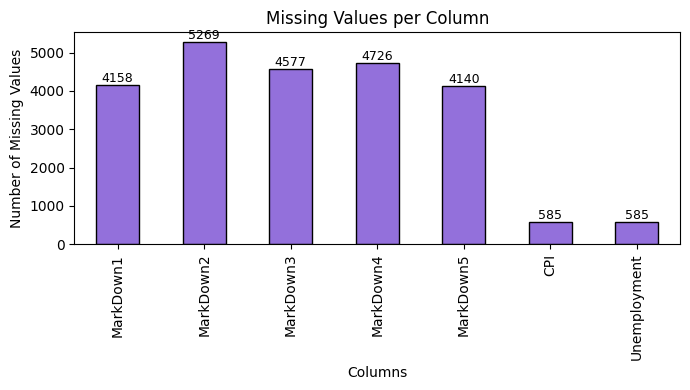

In [219]:
# Visualize missing vlues
missing = features_df.isnull().sum()[lambda x: x > 0] 

plt.figure(figsize=(7,4))
ax = missing.plot(kind='bar', color='mediumpurple', edgecolor='black')
for i, v in enumerate(missing):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=9)

plt.title("Missing Values per Column")
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [220]:
# Duplicates
features_df.duplicated().sum()

0

In [221]:
# Descriptive statistics
features_df.describe().T

count         mean           std       min          25%  \
Store         8190.0    23.000000     12.987966     1.000    12.000000   
Temperature   8190.0    59.356198     18.678607    -7.290    45.902500   
Fuel_Price    8190.0     3.405992      0.431337     2.472     3.041000   
MarkDown1     4032.0  7032.371786   9262.747448 -2781.450  1577.532500   
MarkDown2     2921.0  3384.176594   8793.583016  -265.760    68.880000   
MarkDown3     3613.0  1760.100180  11276.462208  -179.260     6.600000   
MarkDown4     3464.0  3292.935886   6792.329861     0.220   304.687500   
MarkDown5     4050.0  4132.216422  13086.690278  -185.170  1440.827500   
CPI           7605.0   172.460809     39.738346   126.064   132.364839   
Unemployment  7605.0     7.826821      1.877259     3.684     6.634000   

                      50%          75%            max  
Store           23.000000    34.000000      45.000000  
Temperature     60.710000    73.880000     101.950000  
Fuel_Price       3.513000     3.743000       4.468000  
MarkDown1     4743.580000  8923.310000  103184.980000  
MarkDown2      364.570000  2153.350000  104519.540000  
MarkDown3       36.260000   163.150000  149483.310000  
MarkDown4     1176.425000  3310.007500   67474.850000  
MarkDown5     2727.135000  4832.555000  771448.100000  
CPI            182.764003   213.932412     228.976456  
Unemployment     7.806000     8.567000      14.313000

In [222]:
features_df.describe(include=['object', 'bool']).T

count unique         top  freq
Date       8190    182  05/02/2010    45
IsHoliday  8190      2       False  7605

In [223]:
# Unique values
features_df.nunique()

Store             45
Date             182
Temperature     4178
Fuel_Price      1011
MarkDown1       4023
MarkDown2       2715
MarkDown3       2885
MarkDown4       3405
MarkDown5       4045
CPI             2505
Unemployment     404
IsHoliday          2
dtype: int64

#### ***Basic Understanding of features dataset***
- The dataset consists of 8190 rows and 12 columns.
- Some columns in the datset do need conversion of data type.
- Although there are no duplicate values, there are missing values that need to be handled.

#### ***Feature Description***
- Store -> Unique Store Id
- Date -> Timestamp of record
- Temperature -> Average tempurature (External factor that could affect customer/supply chain behaviours)
- Fuel_Price -> Cost of fuel (Economic factor that could affect customer/supply chain behaviours)
- Markdown (1-5) -> Promotional discount/offer values
- CPI -> Consumer Price Index, a metric used for measuring inflation in India
- Unemployment -> Unemployment rate (Economic factor that could affect customer behaviour)
- IsHoliday -> Binary flag indicating holiday weeks

### ***Data Wrangling***

In [224]:
# Merge datasets
df = pd.merge(sales_df, features_df, how = 'left', on = ['Store', 'Date', 'IsHoliday']) # merging sales and features 
merged_df = pd.merge(df, store_df, how = 'left', on = 'Store') # merging df and store
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [225]:
# Make a copy of the dataset
merged_df = merged_df.copy()

# Convert identifiers to category
merged_df['Store'] = merged_df['Store'].astype('category')
merged_df['Dept'] = merged_df['Dept'].astype('category')

# # Convert date to datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'], dayfirst=True)

In [226]:
# Clip negative Weekly_Sales to 0
merged_df["Weekly_Sales_clipped"] = merged_df["Weekly_Sales"].clip(lower=0)

# Check how many records were affected
num_negatives = (merged_df["Weekly_Sales"] < 0).sum()
print(f"Number of negative sales clipped: {num_negatives}")

Number of negative sales clipped: 1285


In [227]:
# Handle missing values
missing_count = df.isnull().sum()[lambda x: x > 0]
missing_percentage = (missing_count / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': missing_percentage
})
missing_df

Missing Count  Missing Percentage
MarkDown1         270889           64.257181
MarkDown2         310322           73.611025
MarkDown3         284479           67.480845
MarkDown4         286603           67.984676
MarkDown5         270138           64.079038

Since these columns represent discounts/offers & more than 50% of the data contain missing values, it is best to assume that there are no discounts or offers were given. Therefore, let's fill all NaN values in these columns with 0

In [228]:
# Markdown columns
md_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
merged_df[md_cols] = merged_df[md_cols].fillna(0)
merged_df.isnull().sum()

Store                   0
Dept                    0
Date                    0
Weekly_Sales            0
IsHoliday               0
Temperature             0
Fuel_Price              0
MarkDown1               0
MarkDown2               0
MarkDown3               0
MarkDown4               0
MarkDown5               0
CPI                     0
Unemployment            0
Type                    0
Size                    0
Weekly_Sales_clipped    0
dtype: int64

In [229]:
merged_df.nunique()

Store                       45
Dept                        81
Date                       143
Weekly_Sales            359464
IsHoliday                    2
Temperature               3528
Fuel_Price                 892
MarkDown1                 2278
MarkDown2                 1499
MarkDown3                 1662
MarkDown4                 1945
MarkDown5                 2294
CPI                       2145
Unemployment               349
Type                         3
Size                        40
Weekly_Sales_clipped    358786
dtype: int64

### ***Anomaly Detection***

In [230]:
# --- IQR Method (Univariate) ---
def detect_iqr_anomalies(df, col="Weekly_Sales_clipped", group_cols=["Store", "Dept"]):
    df = df.copy()
    df["anomaly_iqr"] = False
    
    for keys, group in df.groupby(group_cols, observed=True):
        q1 = group[col].quantile(0.25)
        q3 = group[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        
        mask = (df[group_cols[0]] == keys[0]) & (df[group_cols[1]] == keys[1])
        df.loc[mask & ((df[col] < lower) | (df[col] > upper)), "anomaly_iqr"] = True
    
    return df

merged_df = detect_iqr_anomalies(merged_df)

# --- Rolling Z-Score Method (Time-based) ---
def rolling_zscore(series, window=13):  # ~ quarterly window
    roll_mean = series.rolling(window, min_periods=1, center=True).mean()
    roll_std = series.rolling(window, min_periods=1, center=True).std().replace(0, np.nan)
    return (series - roll_mean) / roll_std

merged_df["anomaly_ts"] = False
for (s, d), group in merged_df.groupby(["Store", "Dept"],observed=True):
    group = group.sort_values("Date")
    z = rolling_zscore(group["Weekly_Sales_clipped"])
    merged_df.loc[group.index, "anomaly_ts"] = z.abs() > 3  # flag anomalies

In [231]:
display(merged_df[["Date", "Weekly_Sales_clipped", "anomaly_iqr", "anomaly_ts"]].sort_values(by="Weekly_Sales_clipped", ascending=True).head(5))
display(merged_df[["Date", "Weekly_Sales_clipped", "anomaly_iqr", "anomaly_ts"]].sort_values(by="Weekly_Sales_clipped", ascending=False).head(5))

Date  Weekly_Sales_clipped  anomaly_iqr  anomaly_ts
183680 2012-04-06                   0.0        False       False
337165 2011-11-04                   0.0        False       False
337462 2012-03-09                   0.0        False       False
63716  2012-09-14                   0.0        False       False
299552 2010-06-18                   0.0        False       False

Date  Weekly_Sales_clipped  anomaly_iqr  anomaly_ts
95373  2010-11-26             693099.36         True       False
338013 2011-11-25             649770.18         True        True
95425  2011-11-25             630999.19         True        True
337961 2010-11-26             627962.93         True        True
135665 2010-11-26             474330.10         True       False

In [232]:
# Evaluate anomalies using statistical thresholds
y_true = merged_df['IsHoliday'].astype(int) # Ground truth (holidays = true anomalies)

# Predictions: IQR method
y_pred_iqr = merged_df['anomaly_iqr'].astype(int)
# Predictions: Time-series method
y_pred_ts = merged_df['anomaly_ts'].astype(int)

# Evaluation metrics
def evaluate_anomalies(y_true, y_pred, method):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{method} → Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

iqr_anomalies = evaluate_anomalies(y_true, y_pred_iqr, "IQR Anomalies")
ts_anomalies = evaluate_anomalies(y_true, y_pred_ts, "Time-Series Anomalies")

IQR Anomalies → Precision: 0.16, Recall: 0.10, F1: 0.12
Time-Series Anomalies → Precision: 0.17, Recall: 0.00, F1: 0.01


Agreement between methods: 398
Total IQR anomalies: 17950, Total TS anomalies: 479


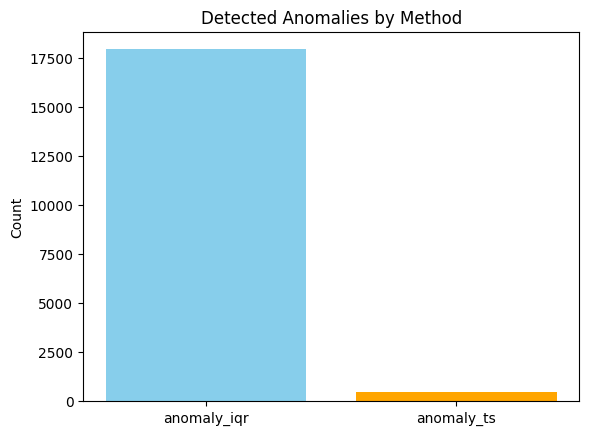

In [233]:
# Compare how many anomalies both methods agree on
agreement = (merged_df['anomaly_iqr'] & merged_df['anomaly_ts']).sum()
total_iqr = merged_df['anomaly_iqr'].sum()
total_ts = merged_df['anomaly_ts'].sum()

print(f"Agreement between methods: {agreement}")
print(f"Total IQR anomalies: {total_iqr}, Total TS anomalies: {total_ts}")

# Visualize
methods = ['anomaly_iqr','anomaly_ts']
counts = [merged_df[m].sum() for m in methods]

plt.bar(methods, counts, color=['skyblue','orange'])
plt.title("Detected Anomalies by Method")
plt.ylabel("Count")
plt.show()

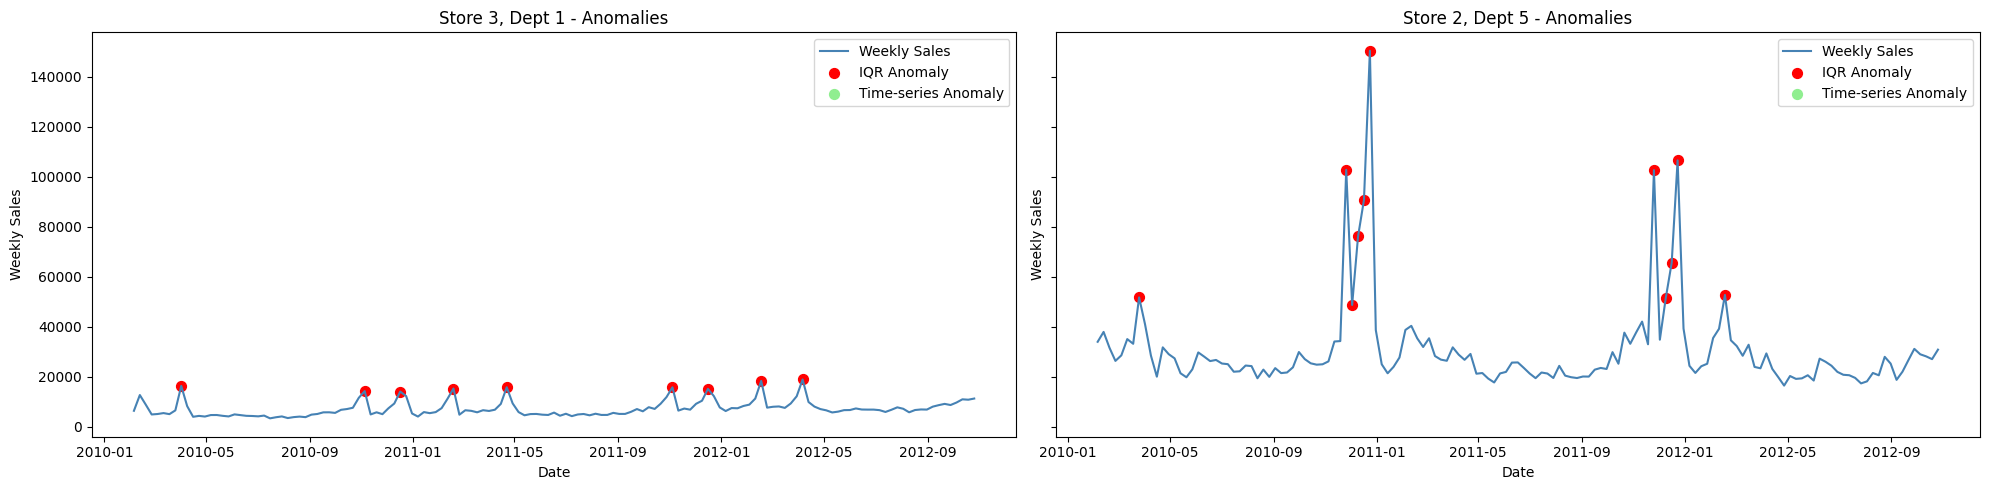

In [234]:
# Visualization of Anomalies
pairs = [(3, 1), (2, 5)] # Choose any 2 store-dept pair for visualization

fig, axes = plt.subplots(1, 2, figsize=(20,5), sharey=True)

for ax, (store, dept) in zip(axes, pairs):
    subset = merged_df[(merged_df["Store"] == store) & 
                       (merged_df["Dept"] == dept)].sort_values("Date")

    ax.plot(subset["Date"], subset["Weekly_Sales_clipped"], label="Weekly Sales", color="steelblue")

    # Highlight anomalies
    ax.scatter(subset["Date"][subset["anomaly_iqr"]], 
               subset["Weekly_Sales_clipped"][subset["anomaly_iqr"]], 
               color="red", label="IQR Anomaly", s=50)

    ax.scatter(subset["Date"][subset["anomaly_ts"]], 
               subset["Weekly_Sales_clipped"][subset["anomaly_ts"]], 
               color="lightgreen", label="Time-series Anomaly", s=50)

    ax.set_title(f"Store {store}, Dept {dept} - Anomalies")
    ax.set_xlabel("Date")
    ax.set_ylabel("Weekly Sales")
    ax.legend()

plt.tight_layout()
plt.show()

- ***Store 3, Dept 1:*** Sales are mostly flat with holiday-driven spikes — anomalies reflect seasonal peaks, not errors.
- ***Store 2, Dept 5:*** Sales show irregular, very high spikes — likely from promotions or special events, making demand more volatile.

***Anomaly Treatment Justification:***
The anomalies detected (holiday spikes, extreme markdown weeks) were retained in the dataset as they represent **true business events** rather than data errors. These anomalies capture critical demand fluctuations that directly impact forecasting accuracy, inventory planning, and promotional strategy.

### ***Feature Engineering***

In [235]:
# Feature Engineering
def feature_engineering(df):
    '''Create time-based & business-specific features
        Time-based: Year, Month, Quarter, WeekOfYear
        Store-related: Size_Category, Sales_per_sqft
        Holiday indicators: IsHoliday, IsHoliday_NextWeek
        Lag features: Sales_Lag1, Sales_Lag2
        Moving averages: Sales_MA3, Sales_MA6
        Promotions: Total_MarkDown, Has_MarkDown'''

    df = df.copy()

    # Extract time-based features
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Quarter"] = df["Date"].dt.quarter
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)
    df["DayOfWeek"] = df["Date"].dt.dayofweek  # 0=Mon, 6=Sun (though all are Fri in this dataset)

    # Store related features
    df["Type"] = df["Type"].astype("category") # Store Type (already in dataset)
    df['Sales_per_sqft'] = df['Weekly_Sales_clipped'] / df['Size'] # Sales per square foot
    df['Size_Category'] = pd.cut(df['Size'], 
                                bins=[0, 50000, 100000, 150000, float('inf')], labels=['Small', 'Medium', 'Large', 'XLarge']) # Size categories
    
    # 3. Holiday indicators
    df["IsHoliday"] = df["IsHoliday"].astype(int)  # convert from bool → int
    df["IsHoliday_NextWeek"] = df.groupby(["Store", "Dept"], observed=True)["IsHoliday"].shift(-1).fillna(0).astype(int)

    # Lag features
    df = df.sort_values(["Store", "Dept", "Date"])
    df["Sales_Lag1"] = df.groupby(["Store", "Dept"], observed=True)["Weekly_Sales_clipped"].shift(1)
    df["Sales_Lag2"] = df.groupby(["Store", "Dept"], observed=True)["Weekly_Sales_clipped"].shift(2)
    
    # Moving averages
    df["Sales_MA3"] = (df.groupby(["Store", "Dept"], observed=True)["Weekly_Sales_clipped"].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()))
    df["Sales_MA6"] = (df.groupby(["Store", "Dept"], observed=True)["Weekly_Sales_clipped"].transform(lambda x: x.shift(1).rolling(window=6, min_periods=1).mean()))
    
    # Markdown features
    md_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    df['Total_MarkDown'] = df[md_cols].sum(axis=1) # Total markdown amount
    df['Has_MarkDown'] = (df['Total_MarkDown'] > 0).astype(int)

    # Drop rows with NaNs in lag features (first 1–2 rows of each series)
    df = df.dropna(subset=['Sales_Lag1', 'Sales_Lag2']).reset_index(drop=True)

    return df

fe_data = feature_engineering(merged_df)

In [236]:
fe_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414945 entries, 0 to 414944
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Store                 414945 non-null  category      
 1   Dept                  414945 non-null  category      
 2   Date                  414945 non-null  datetime64[ns]
 3   Weekly_Sales          414945 non-null  float64       
 4   IsHoliday             414945 non-null  int32         
 5   Temperature           414945 non-null  float64       
 6   Fuel_Price            414945 non-null  float64       
 7   MarkDown1             414945 non-null  float64       
 8   MarkDown2             414945 non-null  float64       
 9   MarkDown3             414945 non-null  float64       
 10  MarkDown4             414945 non-null  float64       
 11  MarkDown5             414945 non-null  float64       
 12  CPI                   414945 non-null  float64       
 13 

In [237]:
# Save the feature engineered dataset
fe_data.to_csv(r'C:\Users\spand\Projects\LABMENTIX_PROJECTS\Retail_Analytics_Store_Optimization\Data\Processed\FE_Dataset.csv', index=False)

In [238]:
fe_data.describe().T

count                           mean  \
Date                    414945  2011-06-25 18:16:01.613708032   
Weekly_Sales          414945.0                   15999.747539   
IsHoliday             414945.0                       0.064218   
Temperature           414945.0                      60.479424   
Fuel_Price            414945.0                       3.370836   
MarkDown1             414945.0                    2630.189413   
MarkDown2             414945.0                     893.296566   
MarkDown3             414945.0                     469.823473   
MarkDown4             414945.0                    1099.913444   
MarkDown5             414945.0                    1687.266252   
CPI                   414945.0                      171.25655   
Unemployment          414945.0                       7.950904   
Size                  414945.0                  136768.881837   
Weekly_Sales_clipped  414945.0                   15999.941796   
Year                  414945.0                    2010.983236   
Month                 414945.0                       6.514454   
Quarter               414945.0                       2.504498   
WeekOfYear            414945.0                      26.123301   
DayOfWeek             414945.0                            4.0   
Sales_per_sqft        414945.0                       0.129763   
IsHoliday_NextWeek    414945.0                       0.064184   
Sales_Lag1            414945.0                   16006.806664   
Sales_Lag2            414945.0                   16017.997765   
Sales_MA3             414945.0                   16016.640395   
Sales_MA6             414945.0                   16026.774382   
Total_MarkDown        414945.0                    6780.489147   
Has_MarkDown          414945.0                       0.364586   

                                      min                  25%  \
Date                  2010-02-19 00:00:00  2010-10-22 00:00:00   
Weekly_Sales                     -4988.94               2100.0   
IsHoliday                             0.0                  0.0   
Temperature                         -2.06                 47.3   
Fuel_Price                          2.472                2.942   
MarkDown1                             0.0                  0.0   
MarkDown2                         -265.76                  0.0   
MarkDown3                           -29.1                  0.0   
MarkDown4                             0.0                  0.0   
MarkDown5                             0.0                  0.0   
CPI                               126.064             132.1062   
Unemployment                        3.879                6.891   
Size                              34875.0              93638.0   
Weekly_Sales_clipped                  0.0               2100.0   
Year                               2010.0               2010.0   
Month                                 1.0                  4.0   
Quarter                               1.0                  2.0   
WeekOfYear                            1.0                 14.0   
DayOfWeek                             4.0                  4.0   
Sales_per_sqft                        0.0             0.017473   
IsHoliday_NextWeek                    0.0                  0.0   
Sales_Lag1                            0.0               2100.5   
Sales_Lag2                            0.0              2100.85   
Sales_MA3                             0.0          2150.636667   
Sales_MA6                             0.0             2189.685   
Total_MarkDown                        0.0                  0.0   
Has_MarkDown                          0.0                  0.0   

                                      50%                  75%  \
Date                  2011-06-24 00:00:00  2012-02-24 00:00:00   
Weekly_Sales                      7631.19             20236.42   
IsHoliday                             0.0                  0.0   
Temperature                         62.54                74.49   
Fuel_Price               

In [239]:
fe_data.describe(include=['category', 'bool']).T

count unique     top    freq
Store          414945     45      13   10318
Dept           414945     81       1    6345
Type           414945      3       A  212148
anomaly_iqr    414945      2   False  397585
anomaly_ts     414945      2   False  414466
Size_Category  414945      4  XLarge  199685

In [240]:
# Split categorical & numerical features
cat_features = fe_data.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print(f'The categorical features: {len(cat_features)}\n{cat_features}\n')

num_features = fe_data.select_dtypes(include=['number']).columns.tolist()
print(f'The numerical features: {len(num_features)}:\n{num_features}')

The categorical features: 6
['Store', 'Dept', 'Type', 'anomaly_iqr', 'anomaly_ts', 'Size_Category']

The numerical features: 26:
['Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Weekly_Sales_clipped', 'Year', 'Month', 'Quarter', 'WeekOfYear', 'DayOfWeek', 'Sales_per_sqft', 'IsHoliday_NextWeek', 'Sales_Lag1', 'Sales_Lag2', 'Sales_MA3', 'Sales_MA6', 'Total_MarkDown', 'Has_MarkDown']


### ***Exploratory Data Analysis***

#### ***Time-series Analysis***

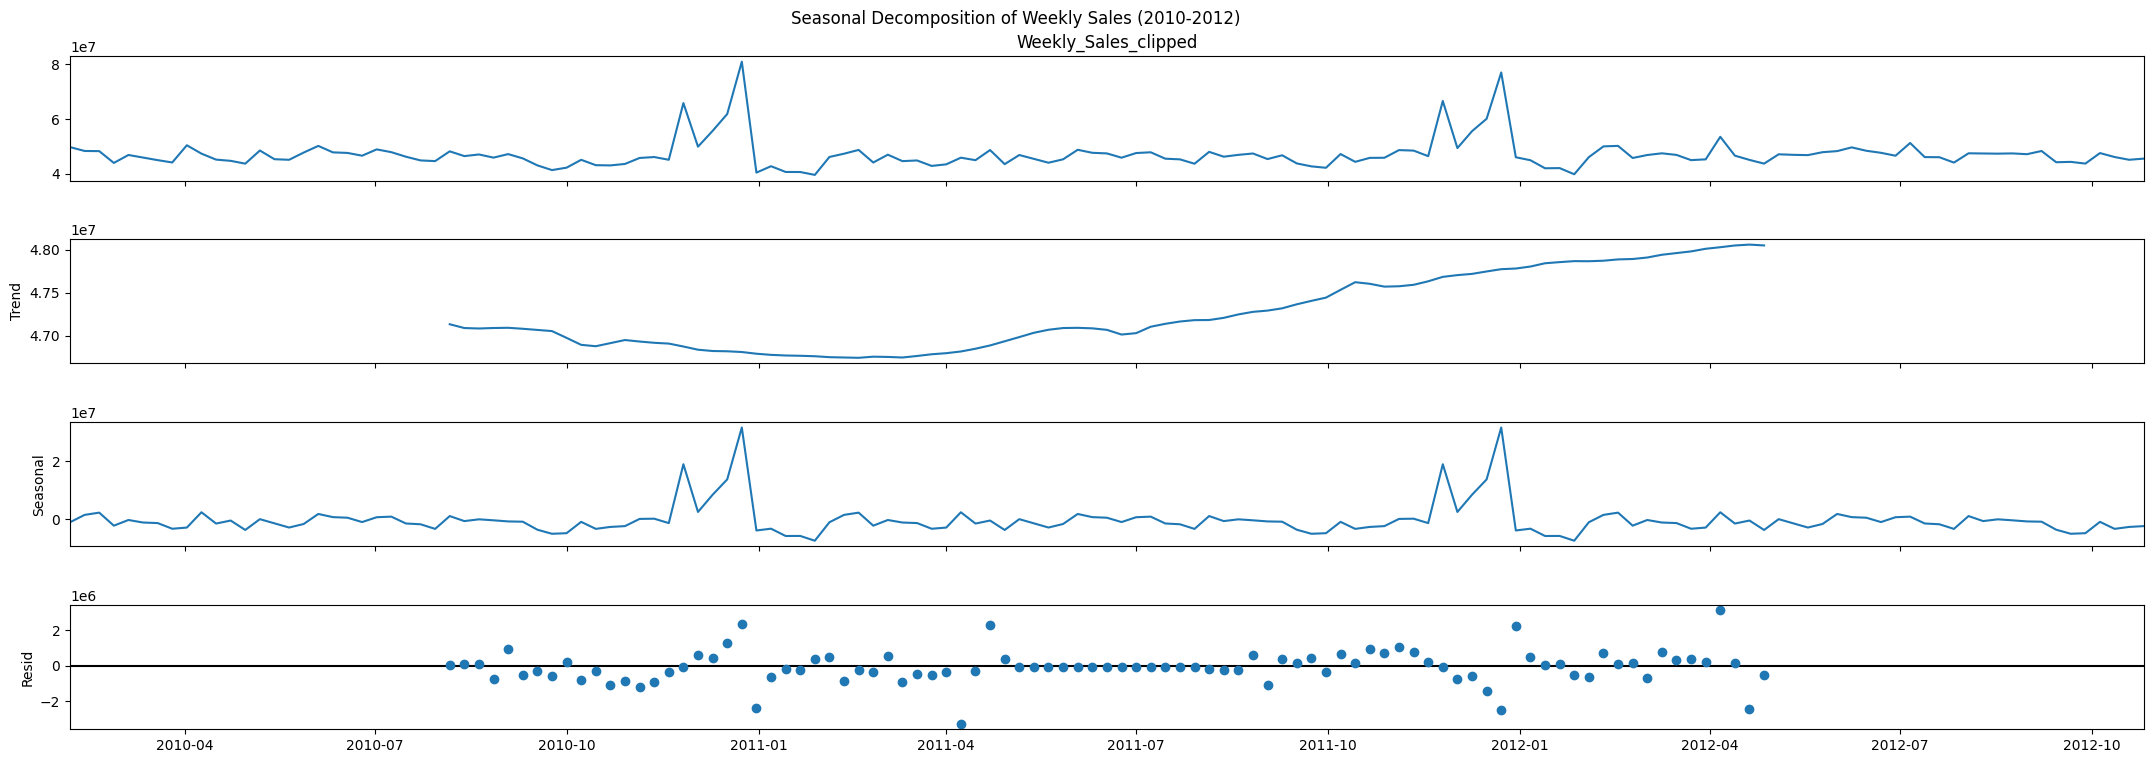

In [241]:
# Seasonal Decomposition
ts = merged_df.set_index("Date")["Weekly_Sales_clipped"].resample("W-FRI").sum() # Aggregate sales at weekly frequency directly

# Decompose (yearly seasonality ≈ 52 weeks)
result = seasonal_decompose(ts, model="additive", period=52)

# Plot decomposition
fig = result.plot()
fig.set_size_inches(25, 8)
plt.suptitle("Seasonal Decomposition of Weekly Sales (2010-2012)")
plt.show()

#### ***Seasonal decomposition Analysis:***
- ***Observed:*** Weekly sales show sharp spikes around certain periods, likely holidays or promotions.
- ***Trend:*** The long-term sales trend is relatively flat with slight recovery after mid-2011.
- ***Seasonal:*** Strong recurring seasonal peaks align with holiday periods each year.
- ***Residual:*** Residuals capture random fluctuations and extreme anomalies not explained by trend or seasonality.

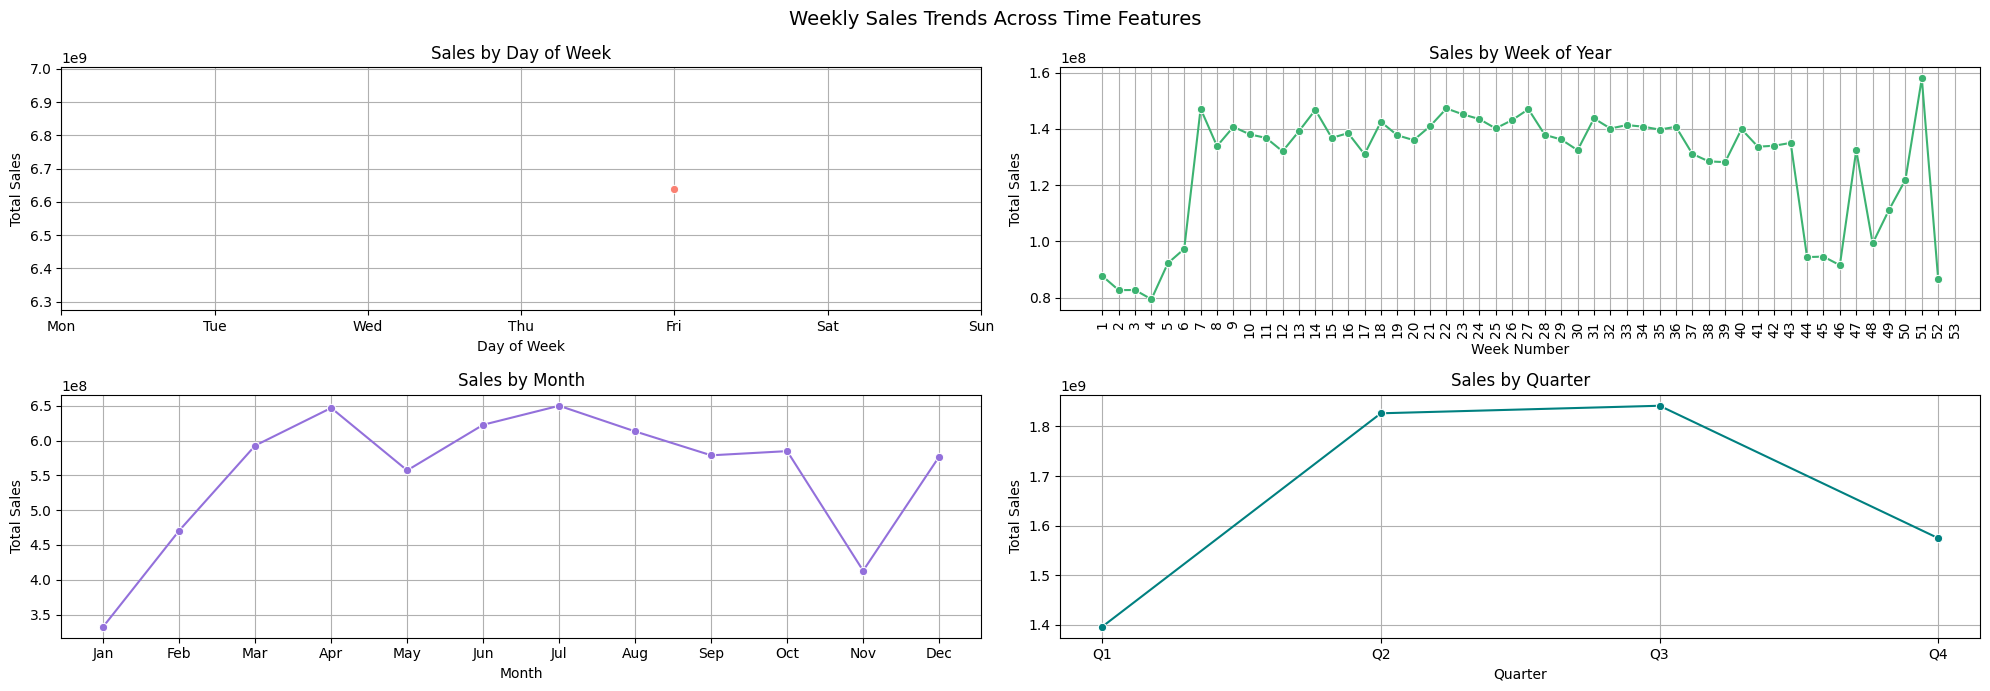

In [242]:
# Weekly Sales Trends Across Time Features
fig, axes = plt.subplots(2, 2, figsize=(20, 7))
plt.suptitle("Weekly Sales Trends Across Time Features", fontsize=14)

day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
quarter_map = {1: "Q1", 2: "Q2", 3: "Q3", 4: "Q4"}

# 1. Sales by Day of Week
dow = fe_data.groupby("DayOfWeek")["Weekly_Sales_clipped"].sum()
sns.lineplot(ax=axes[0, 0], x=dow.index, y=dow.values, marker='o', color='salmon')
axes[0, 0].set_title("Sales by Day of Week")
axes[0, 0].set_xlabel("Day of Week")
axes[0, 0].set_ylabel("Total Sales")
axes[0, 0].set_xticks(list(day_map.keys()))
axes[0, 0].set_xticklabels([day_map[i] for i in day_map])
axes[0, 0].grid(True)

# 2. Sales by Week of Year
weekly = fe_data.groupby("WeekOfYear")["Weekly_Sales_clipped"].sum()
sns.lineplot(ax=axes[0, 1], x=weekly.index, y=weekly.values, marker='o', color='mediumseagreen')
axes[0, 1].set_title("Sales by Week of Year")
axes[0, 1].set_xlabel("Week Number")
axes[0, 1].set_ylabel("Total Sales")
axes[0, 1].set_xticks(range(1, 54))
axes[0, 1].tick_params(axis='x', rotation=90)
axes[0, 1].grid(True)

# 3. Sales by Month
monthly = fe_data.groupby("Month")["Weekly_Sales_clipped"].sum()
sns.lineplot(ax=axes[1, 0], x=monthly.index, y=monthly.values, marker='o', color='mediumpurple')
axes[1, 0].set_title("Sales by Month")
axes[1, 0].set_xlabel("Month")
axes[1, 0].set_ylabel("Total Sales")
axes[1, 0].set_xticks(list(month_map.keys()))
axes[1, 0].set_xticklabels([month_map[i] for i in month_map])
axes[1, 0].grid(True)

# 4. Sales by Quarter
quarterly = fe_data.groupby("Quarter")["Weekly_Sales_clipped"].sum()
sns.lineplot(ax=axes[1, 1], x=quarterly.index, y=quarterly.values, marker='o', color='teal')
axes[1, 1].set_title("Sales by Quarter")
axes[1, 1].set_xlabel("Quarter")
axes[1, 1].set_ylabel("Total Sales")
axes[1, 1].set_xticks(list(quarter_map.keys()))
axes[1, 1].set_xticklabels([quarter_map[i] for i in quarter_map])
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

- ***Sales by Day of Week:*** All sales occur on Fridays, confirming consistent weekly reporting.
- ***Sales by Week of Year:*** Peaks around weeks 6–7 and week 51 indicate holiday-driven sales surges.
- ***Sales by Month:*** Sales rise in spring (Mar–Jul), dip in November, and rebound in December.
- ***Sales by Quarter:*** Q2 and Q3 show the highest sales, while Q1 is lowest.

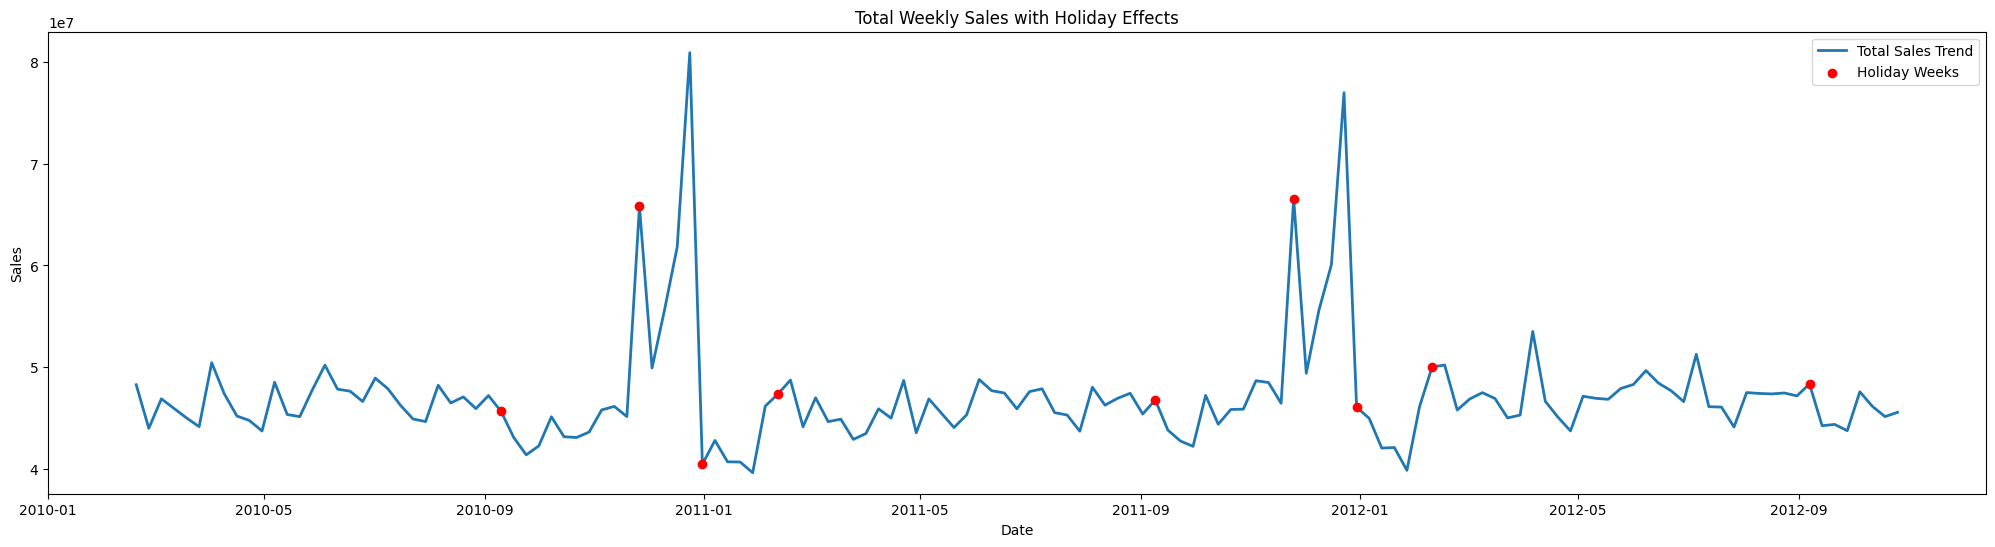

In [243]:
# Overlay holiday effects on sales trends
# Aggregate weekly sales across all stores & depts
weekly_sales = fe_data.groupby("Date", as_index=False)["Weekly_Sales"].sum()

holiday_sales = weekly_sales[weekly_sales['Date'].isin(
    fe_data[fe_data['IsHoliday'] == True]['Date'].unique()
)]

plt.figure(figsize=(25,6))
plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], label="Total Sales Trend", linewidth=2)
plt.scatter(holiday_sales['Date'], holiday_sales['Weekly_Sales'],
            color='red', label="Holiday Weeks", zorder=5)
plt.title("Total Weekly Sales with Holiday Effects")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

#### ***Univariate Analysis***

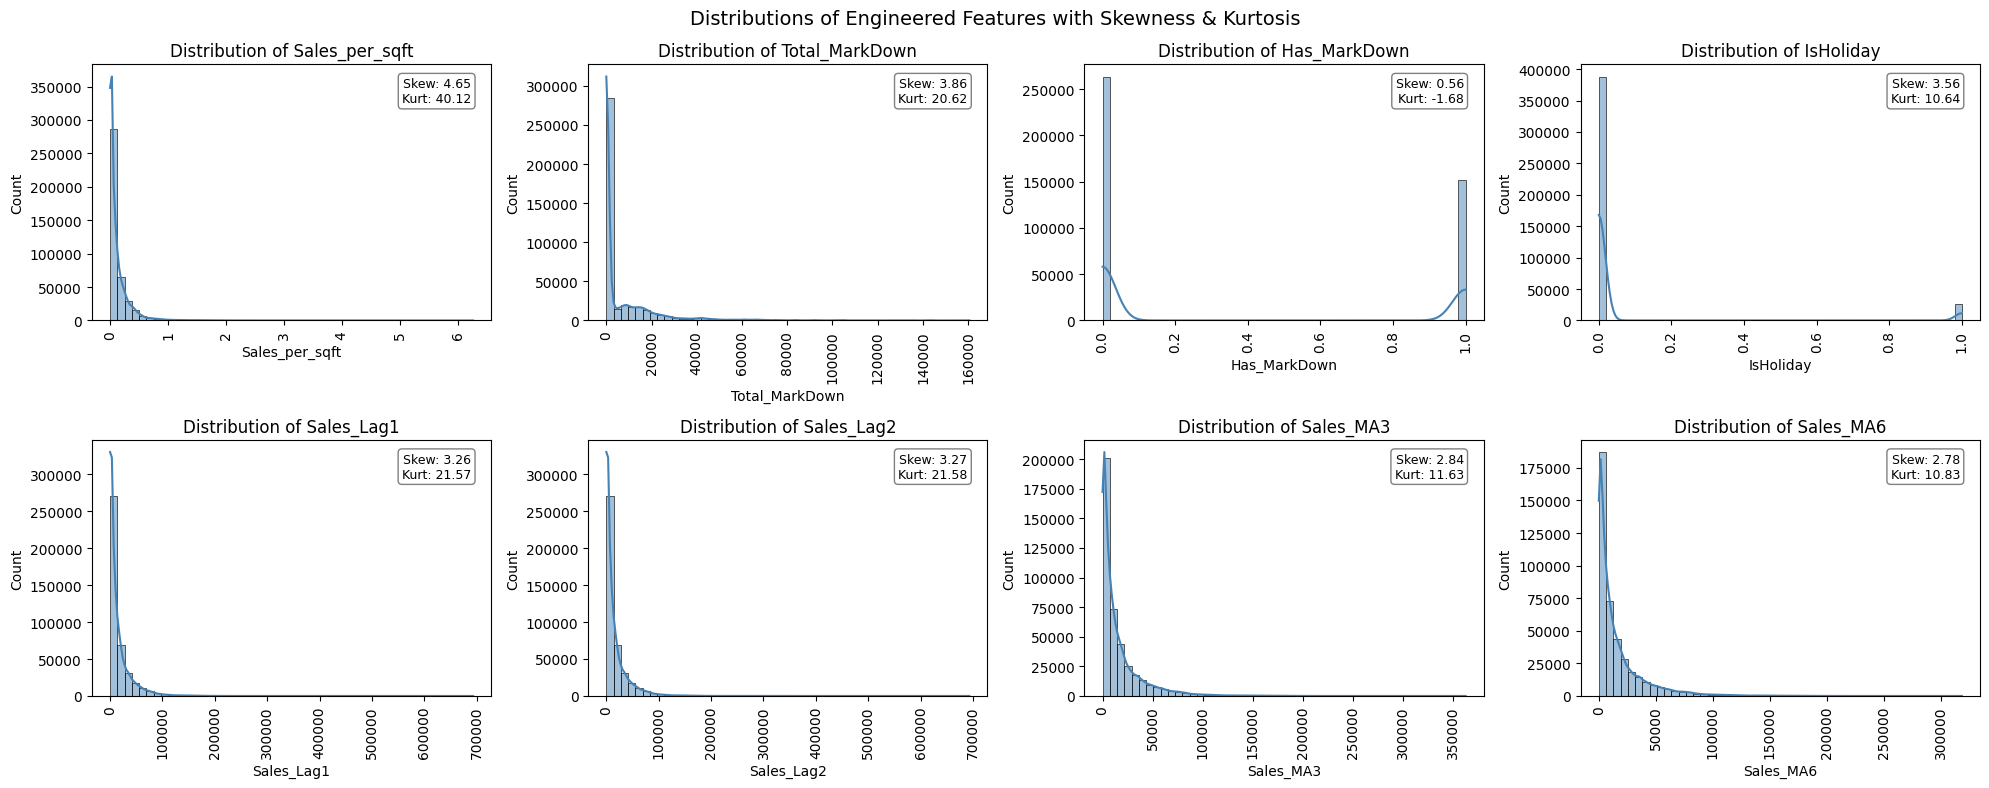

In [244]:
# Check distributions of engineered features with Skewness & Kurtosi
cols = ["Sales_per_sqft", "Total_MarkDown", "Has_MarkDown", "IsHoliday", 
        "Sales_Lag1", "Sales_Lag2", "Sales_MA3", "Sales_MA6"]

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

for i, col in enumerate(cols):
    data = fe_data[col].dropna()
    
    # Plot histogram with KDE
    sns.histplot(data, bins=50, kde=True, color="steelblue", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis="x", rotation=90)
    
    # Compute skewness & kurtosis
    sk = skew(data)
    kurt = kurtosis(data)
    
    # Annotate on plot
    axes[i].annotate(f"Skew: {sk:.2f}\nKurt: {kurt:.2f}", 
                     xy=(0.95, 0.95), xycoords="axes fraction",
                     ha="right", va="top",
                     fontsize=9, bbox=dict(boxstyle="round", fc="white", ec="gray"))

plt.suptitle("Distributions of Engineered Features with Skewness & Kurtosis", fontsize=14)
plt.tight_layout()
plt.show()

- ***Sales_per_sqft:*** Highly right-skewed with extreme kurtosis (outliers dominate distribution).
- ***Total_MarkDown:*** Right-skewed with heavy tails, suggesting irregular promotion spikes.
- ***Has_MarkDown:*** Nearly binary distribution, confirming it’s a categorical indicator feature.
- ***IsHoliday:*** Binary with high skew/kurtosis since only a few weeks are holidays.
- ***Sales_Lag1:*** Strong right skew with high kurtosis, similar pattern to raw sales.
- ***Sales_Lag2:*** Almost identical to Sales_Lag1, indicating persistence in sales trends.
- ***Sales_MA3:*** Right-skewed but smoother than raw lags, capturing short-term sales averages.
- ***Sales_MA6:*** Similar skew but smoother distribution than MA3, reflecting medium-term seasonality.

***Inference:*** Most continuous features are heavily skewed with long tails, meaning transformations (like log or Box-Cox) could stabilize variance and improve model performance.

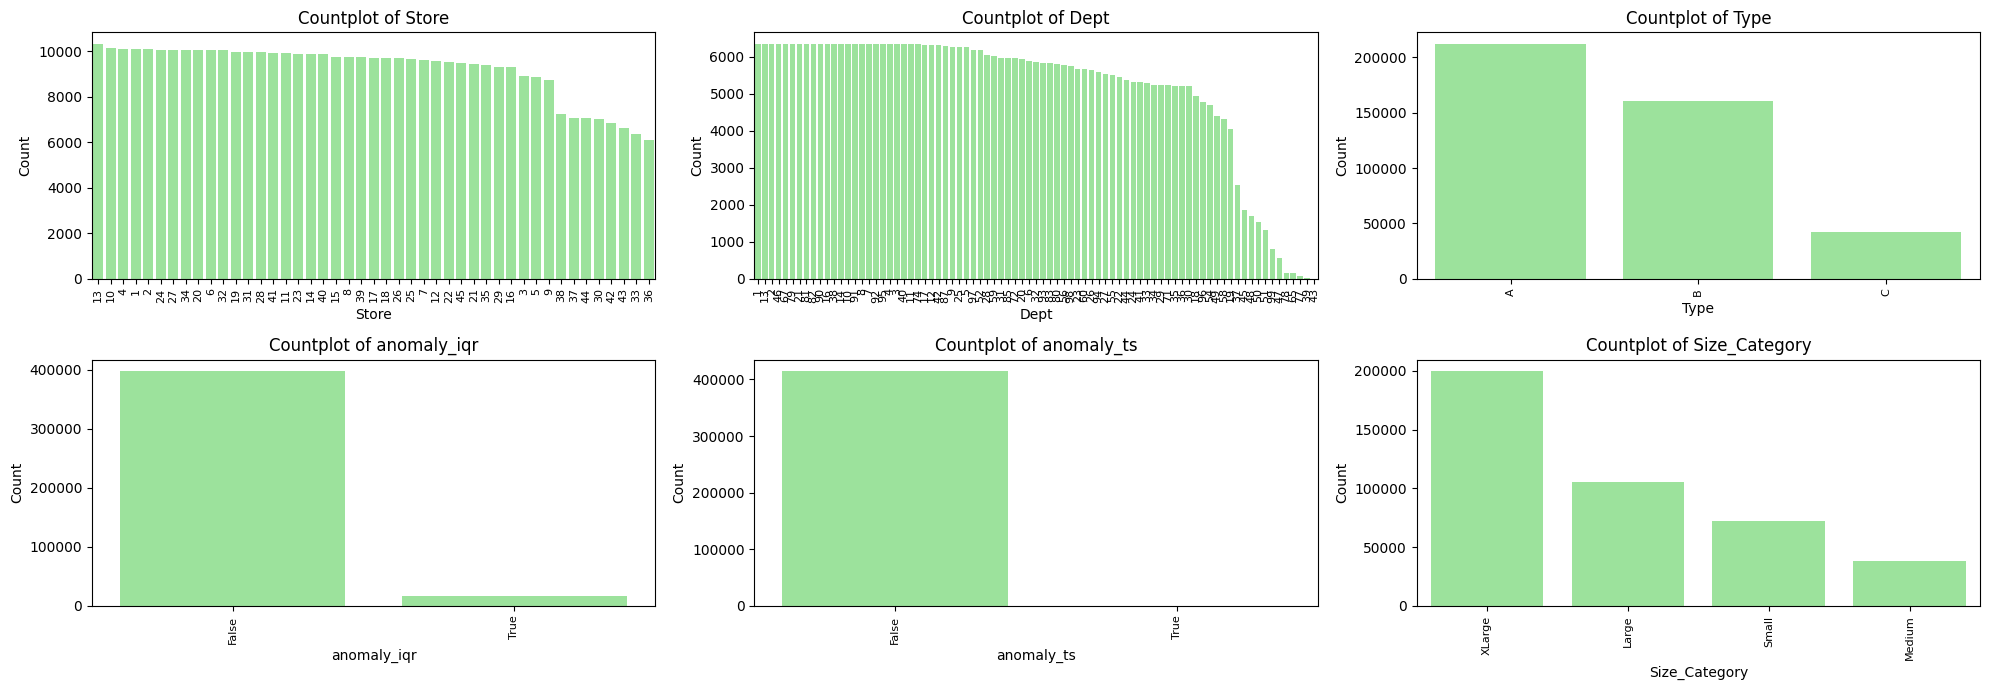

In [245]:
# Categorical Features - Countplots 
# Reasoning: Countplots help us understand the distribution of categories

fig, axes = plt.subplots(2, 3, figsize=(20, 7))  
axes = axes.flatten()

for i, col in enumerate(cat_features):
    sns.countplot(x=fe_data[col], order=fe_data[col].value_counts().index, color="lightgreen", ax=axes[i])
    axes[i].set_title(f"Countplot of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=90, labelsize=8)

plt.tight_layout()
plt.show()

- ***Store:*** All stores have fairly balanced data coverage, though some stores have slightly fewer records.
- ***Department:*** Some departmentshave higher representation, while later ones are underrepresented.
- ***Store Type:*** Type A stores dominate the dataset, followed by B, while Type C stores are relatively few.
- ***anomaly_iqr:*** Only a small fraction of records are flagged as IQR anomalies.
- ***anomaly_ts:*** Very few anomalies are detected via time-series z-score, showing stable trends.
- ***Store Size Category:*** XLarge and Large stores make up most of the data, while Medium stores are least represented.

#### ***Bivariate Analysis***

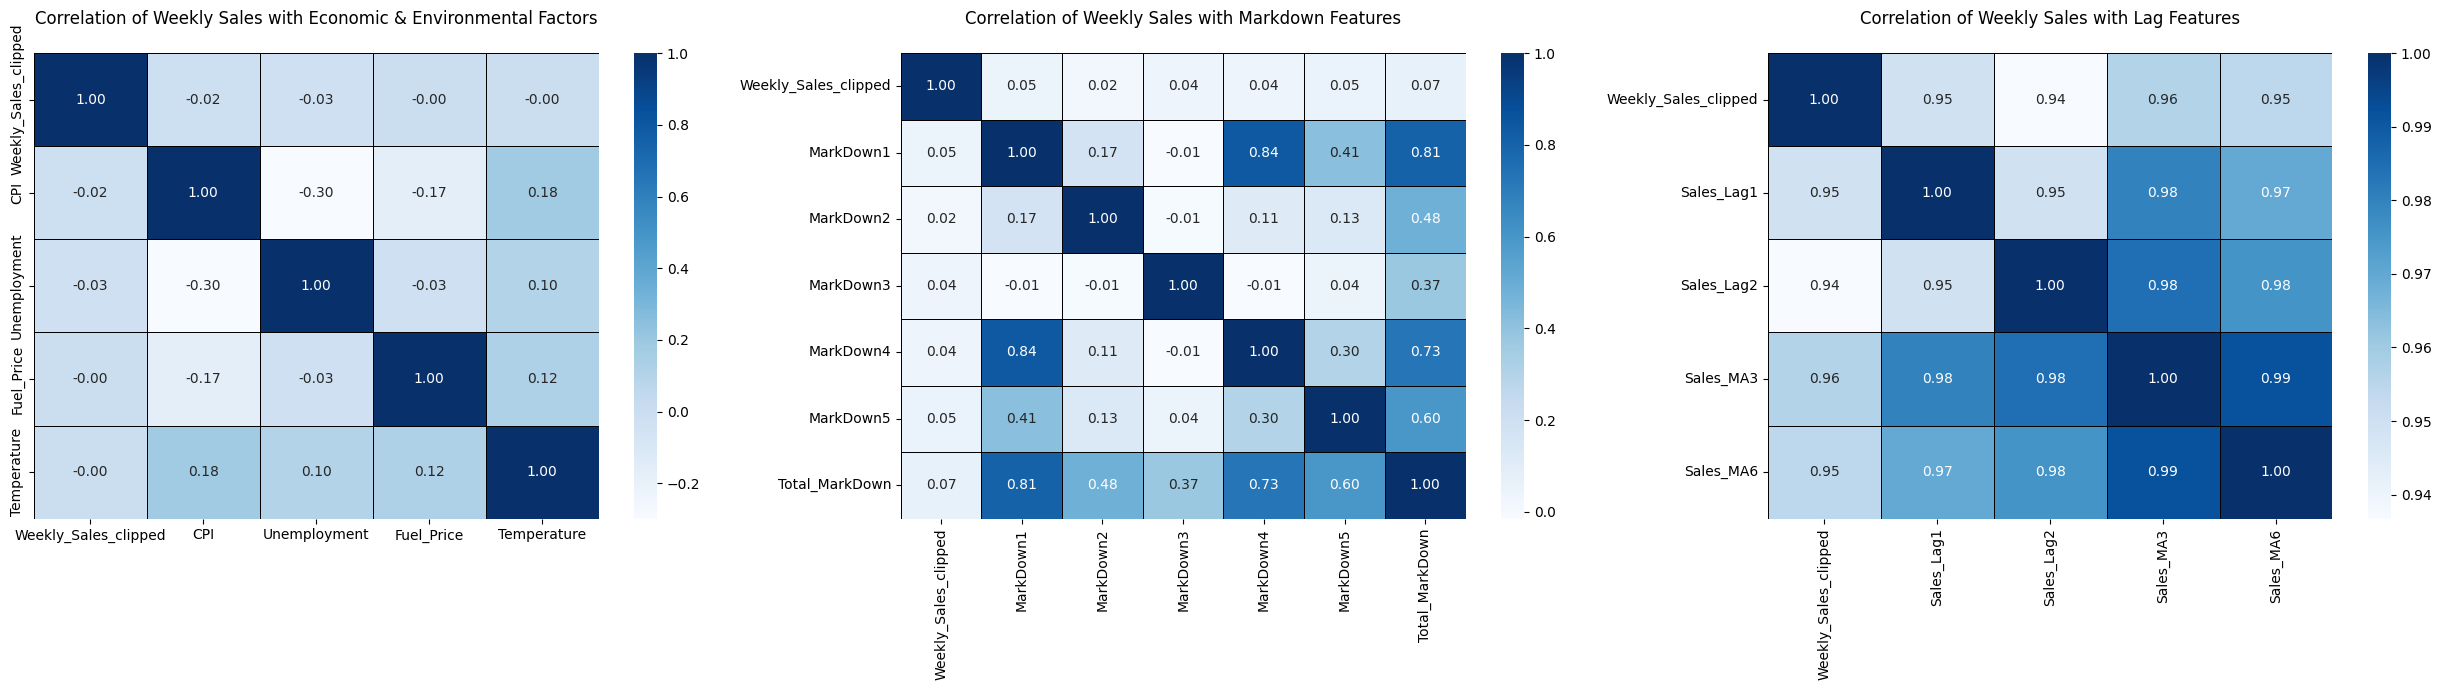

In [246]:
# Correlation Heatmap - Check how new features correlate with Weekly_Sales_clipped
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

# Weekly Sales vs. Economic & Environmental Factors, these factors may affect purchasing power.
corr = fe_data[['Weekly_Sales_clipped','CPI','Unemployment','Fuel_Price','Temperature']].corr()
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5, linecolor="black", ax=axes[0])
axes[0].set_title("Correlation of Weekly Sales with Economic & Environmental Factors\n")

# Select Weekly_Sales_clipped and markdown features
md_cols = [f'MarkDown{i}' for i in range(1, 6)] + ['Total_MarkDown']
corr_md = fe_data[['Weekly_Sales_clipped'] + md_cols].corr()
sns.heatmap(corr_md, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5, linecolor="black", ax=axes[1])
axes[1].set_title("Correlation of Weekly Sales with Markdown Features\n")

# Correlation with lag features
lag_cols = ['Sales_Lag1', 'Sales_Lag2', 'Sales_MA3', 'Sales_MA6']
corr_lags = fe_data[['Weekly_Sales_clipped'] + lag_cols].corr()
sns.heatmap(corr_lags, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5, linecolor="black", ax=axes[2])
axes[2].set_title("Correlation of Weekly Sales with Lag Features\n")

plt.tight_layout()
plt.show()

- ***Economic & Environmental Factors:*** Weekly sales show almost no correlation with CPI, unemployment, fuel price, or temperature, suggesting external factors play a limited role.
- ***Markdown Features:*** Weekly sales have very weak correlation with individual markdowns, but total markdowns show moderate association due to combined effect.
- ***Lag Features:*** Lagged sales (Lag1, Lag2, MA3, MA6) are extremely strong predictors of weekly sales, highlighting strong temporal dependence in sales patterns.

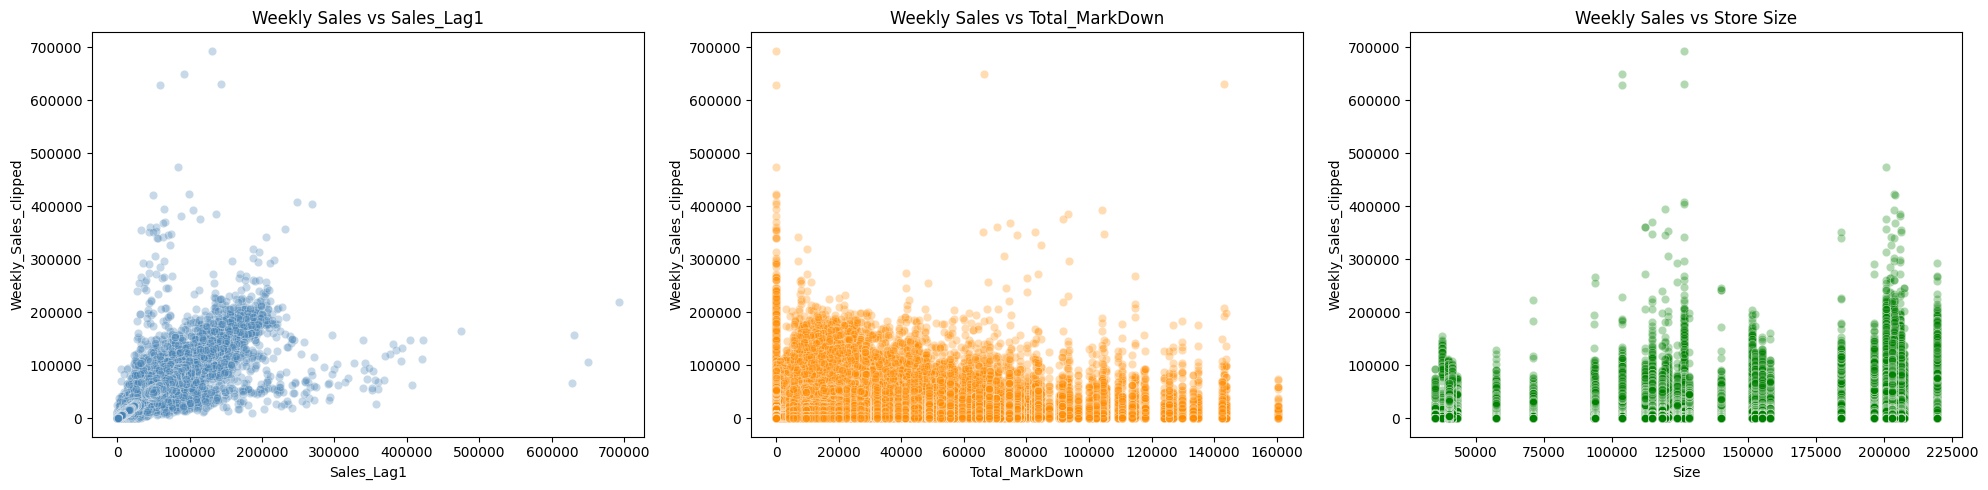

In [247]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1. Scatter: Weekly Sales vs Sales_Lag1
sns.scatterplot(x="Sales_Lag1", y="Weekly_Sales_clipped", data=fe_data, alpha=0.3, ax=axes[0], color="steelblue")
axes[0].set_title("Weekly Sales vs Sales_Lag1")

# 2. Scatter: Weekly Sales vs Total_MarkDown
sns.scatterplot(x="Total_MarkDown", y="Weekly_Sales_clipped", data=fe_data, alpha=0.3, ax=axes[1], color="darkorange")
axes[1].set_title("Weekly Sales vs Total_MarkDown")

# 3. Weekly Sales vs. Store Size (Reasoning: Larger stores may have consistently higher sales – scatterplot shows correlation strength)
sns.scatterplot(x="Size", y="Weekly_Sales_clipped", data=fe_data, alpha=0.3, ax=axes[2], color="green")
axes[2].set_title("Weekly Sales vs Store Size")

plt.tight_layout()
plt.show()

- ***Weekly Sales vs Sales_Lag1:*** Strong positive correlation shows past week’s sales are a strong predictor of current sales.
- ***Weekly Sales vs Total_MarkDown:*** Weak relationship, suggesting markdowns do not consistently drive sales increases.
- ***Weekly Sales vs Store Size:*** Larger stores tend to generate higher sales, though with significant variability.

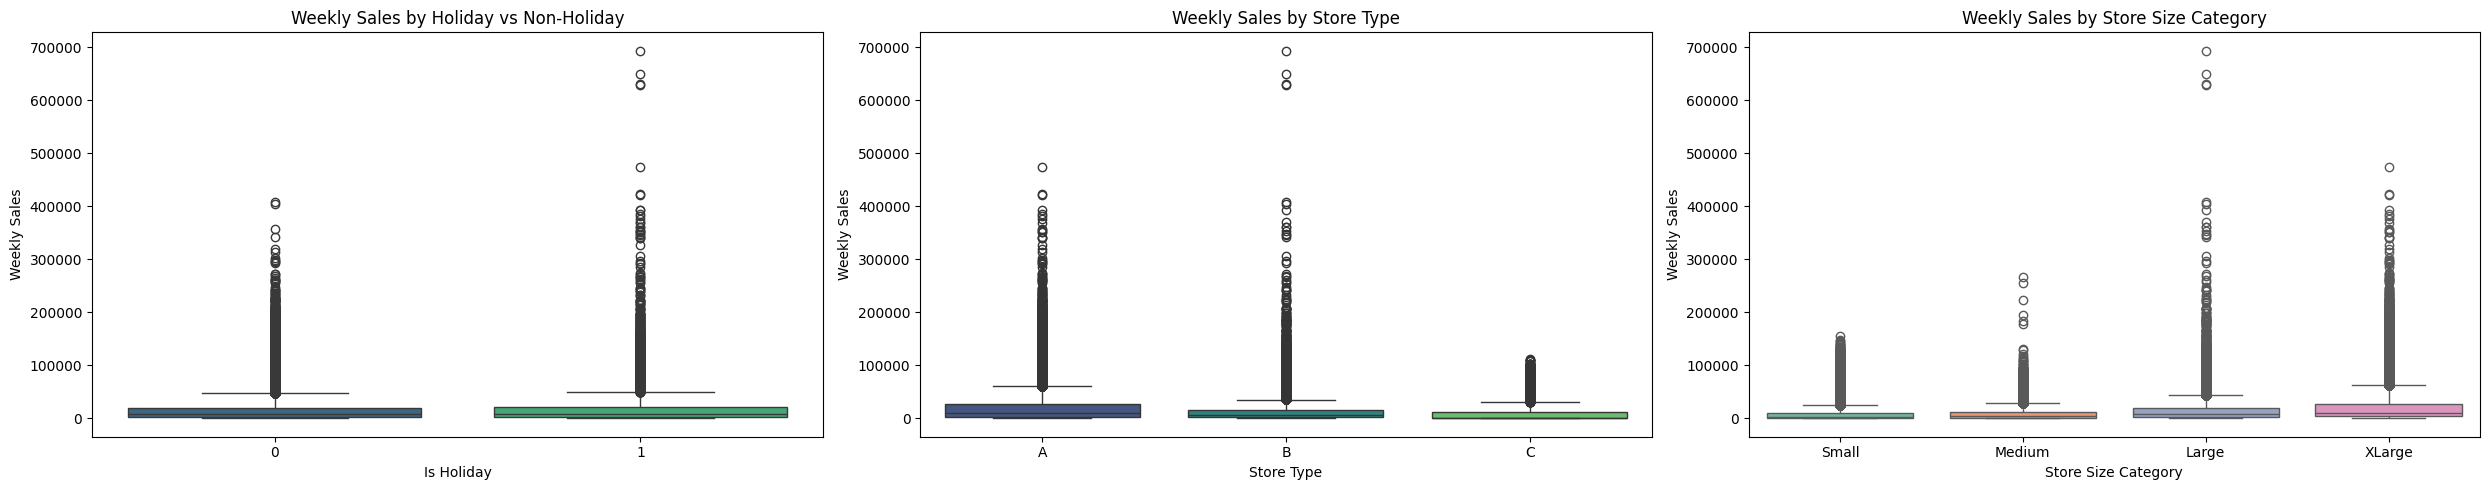

In [248]:
fig, axes = plt.subplots(1, 3, figsize=(25, 5))

# 1. Weekly Sales vs. IsHoliday (Reasoning: Boxplots by holiday status show whether holidays lead to consistent spikes in sales)
sns.boxplot(x="IsHoliday", y="Weekly_Sales_clipped", data=fe_data,
            hue="IsHoliday", palette="viridis", legend=False, ax=axes[0])
axes[0].set_title("Weekly Sales by Holiday vs Non-Holiday")
axes[0].set_xlabel("Is Holiday")
axes[0].set_ylabel("Weekly Sales")

# 2. Weekly Sales vs. Store Type (Reasoning: Different store types (A/B/C) may have distinct sales patterns, important for segmentation and forecasting)
sns.boxplot(x="Type", y="Weekly_Sales_clipped", data=fe_data,
            hue="Type", palette="viridis", legend=False, ax=axes[1])
axes[1].set_title("Weekly Sales by Store Type")
axes[1].set_xlabel("Store Type")
axes[1].set_ylabel("Weekly Sales")

# 3. Weekly Sales by Store Size Category
sns.boxplot(x="Size_Category", y="Weekly_Sales_clipped", data=fe_data, 
            hue="Size_Category", ax=axes[2], legend=False, palette="Set2")
axes[2].set_title("Weekly Sales by Store Size Category")
axes[2].set_xlabel("Store Size Category")
axes[2].set_ylabel("Weekly Sales")

plt.tight_layout()
plt.show()

- ***Weekly Sales by Holiday vs Non-Holiday:*** Holiday weeks generally show slightly higher sales but with extreme outliers.
- ***Weekly Sales by Store Type:*** Type A and B stores achieve higher sales compared to Type C, though with large variability.
- ***Weekly Sales by Store Size Category:*** Larger and XLarge stores have higher sales distributions, confirming size impacts revenue.

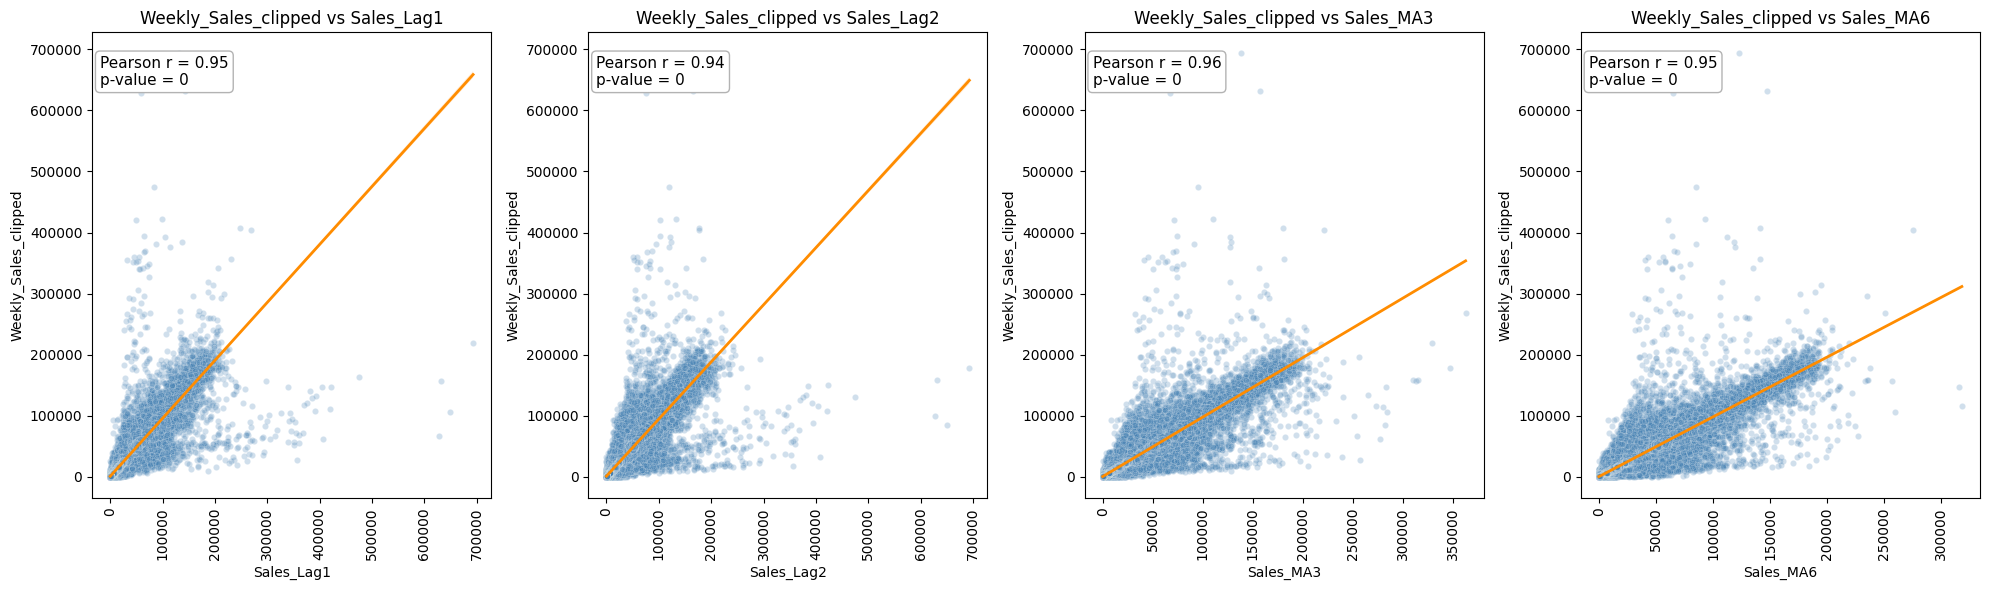

In [249]:
# Relationship between Weekly_Sales_clipped and Lagged features
pairs = [("Sales_Lag1", "Weekly_Sales_clipped"),
         ("Sales_Lag2", "Weekly_Sales_clipped"),
         ("Sales_MA3",   "Weekly_Sales_clipped"),
         ("Sales_MA6",   "Weekly_Sales_clipped")]

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for ax, (x, y) in zip(axes, pairs):
    sub = fe_data[[x, y]].dropna() # drop NA rows for this pair
    
    # Scatterplot - Reasoning: Shows the raw relationship between lag features and Weekly Sales.
    sns.scatterplot(x=x, y=y, data=sub, alpha=0.25, ax=ax, color="steelblue", s=20) 

    # Linear regression line (least squares) - Reasoning: Adds a best-fit linear trend to quantify the direction and strength of association.
    sns.regplot(x=x, y=y, data=sub, scatter=False, ax=ax, line_kws={'color':'darkorange', 'linewidth':2}) 

    # Pearson correlation (quantify association)
    if len(sub) >= 2:
        r, p = stats.pearsonr(sub[x], sub[y])
        ax_text = f"Pearson r = {r:.2f}\np-value = {p:.2g}"
    else:
        ax_text = "Insufficient data"

    # Annotate
    ax.annotate(ax_text, xy=(0.02, 0.95), xycoords='axes fraction',
                ha='left', va='top', fontsize=11,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.7"))

    ax.set_title(f"{y} vs {x}")
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

- ***Weekly_Sales vs Sales_Lag1:*** Strong positive correlation (r=0.95) shows last week’s sales are highly predictive of current week sales.
- ***Weekly_Sales vs Sales_Lag2:*** Two-week lag also has strong correlation (r=0.94), reinforcing sales continuity.
- ***Weekly_Sales vs Sales_MA3:*** Three-week moving average is the strongest predictor (r=0.96), smoothing out noise while retaining trend.
- ***Weekly_Sales vs Sales_MA6:*** Six-week moving average maintains a strong correlation (r=0.95), capturing longer-term patterns.
  
***Inference:*** This confirms lag and moving average features are excellent predictors for your demand forecasting model.

#### ***Multivariate Analysis***

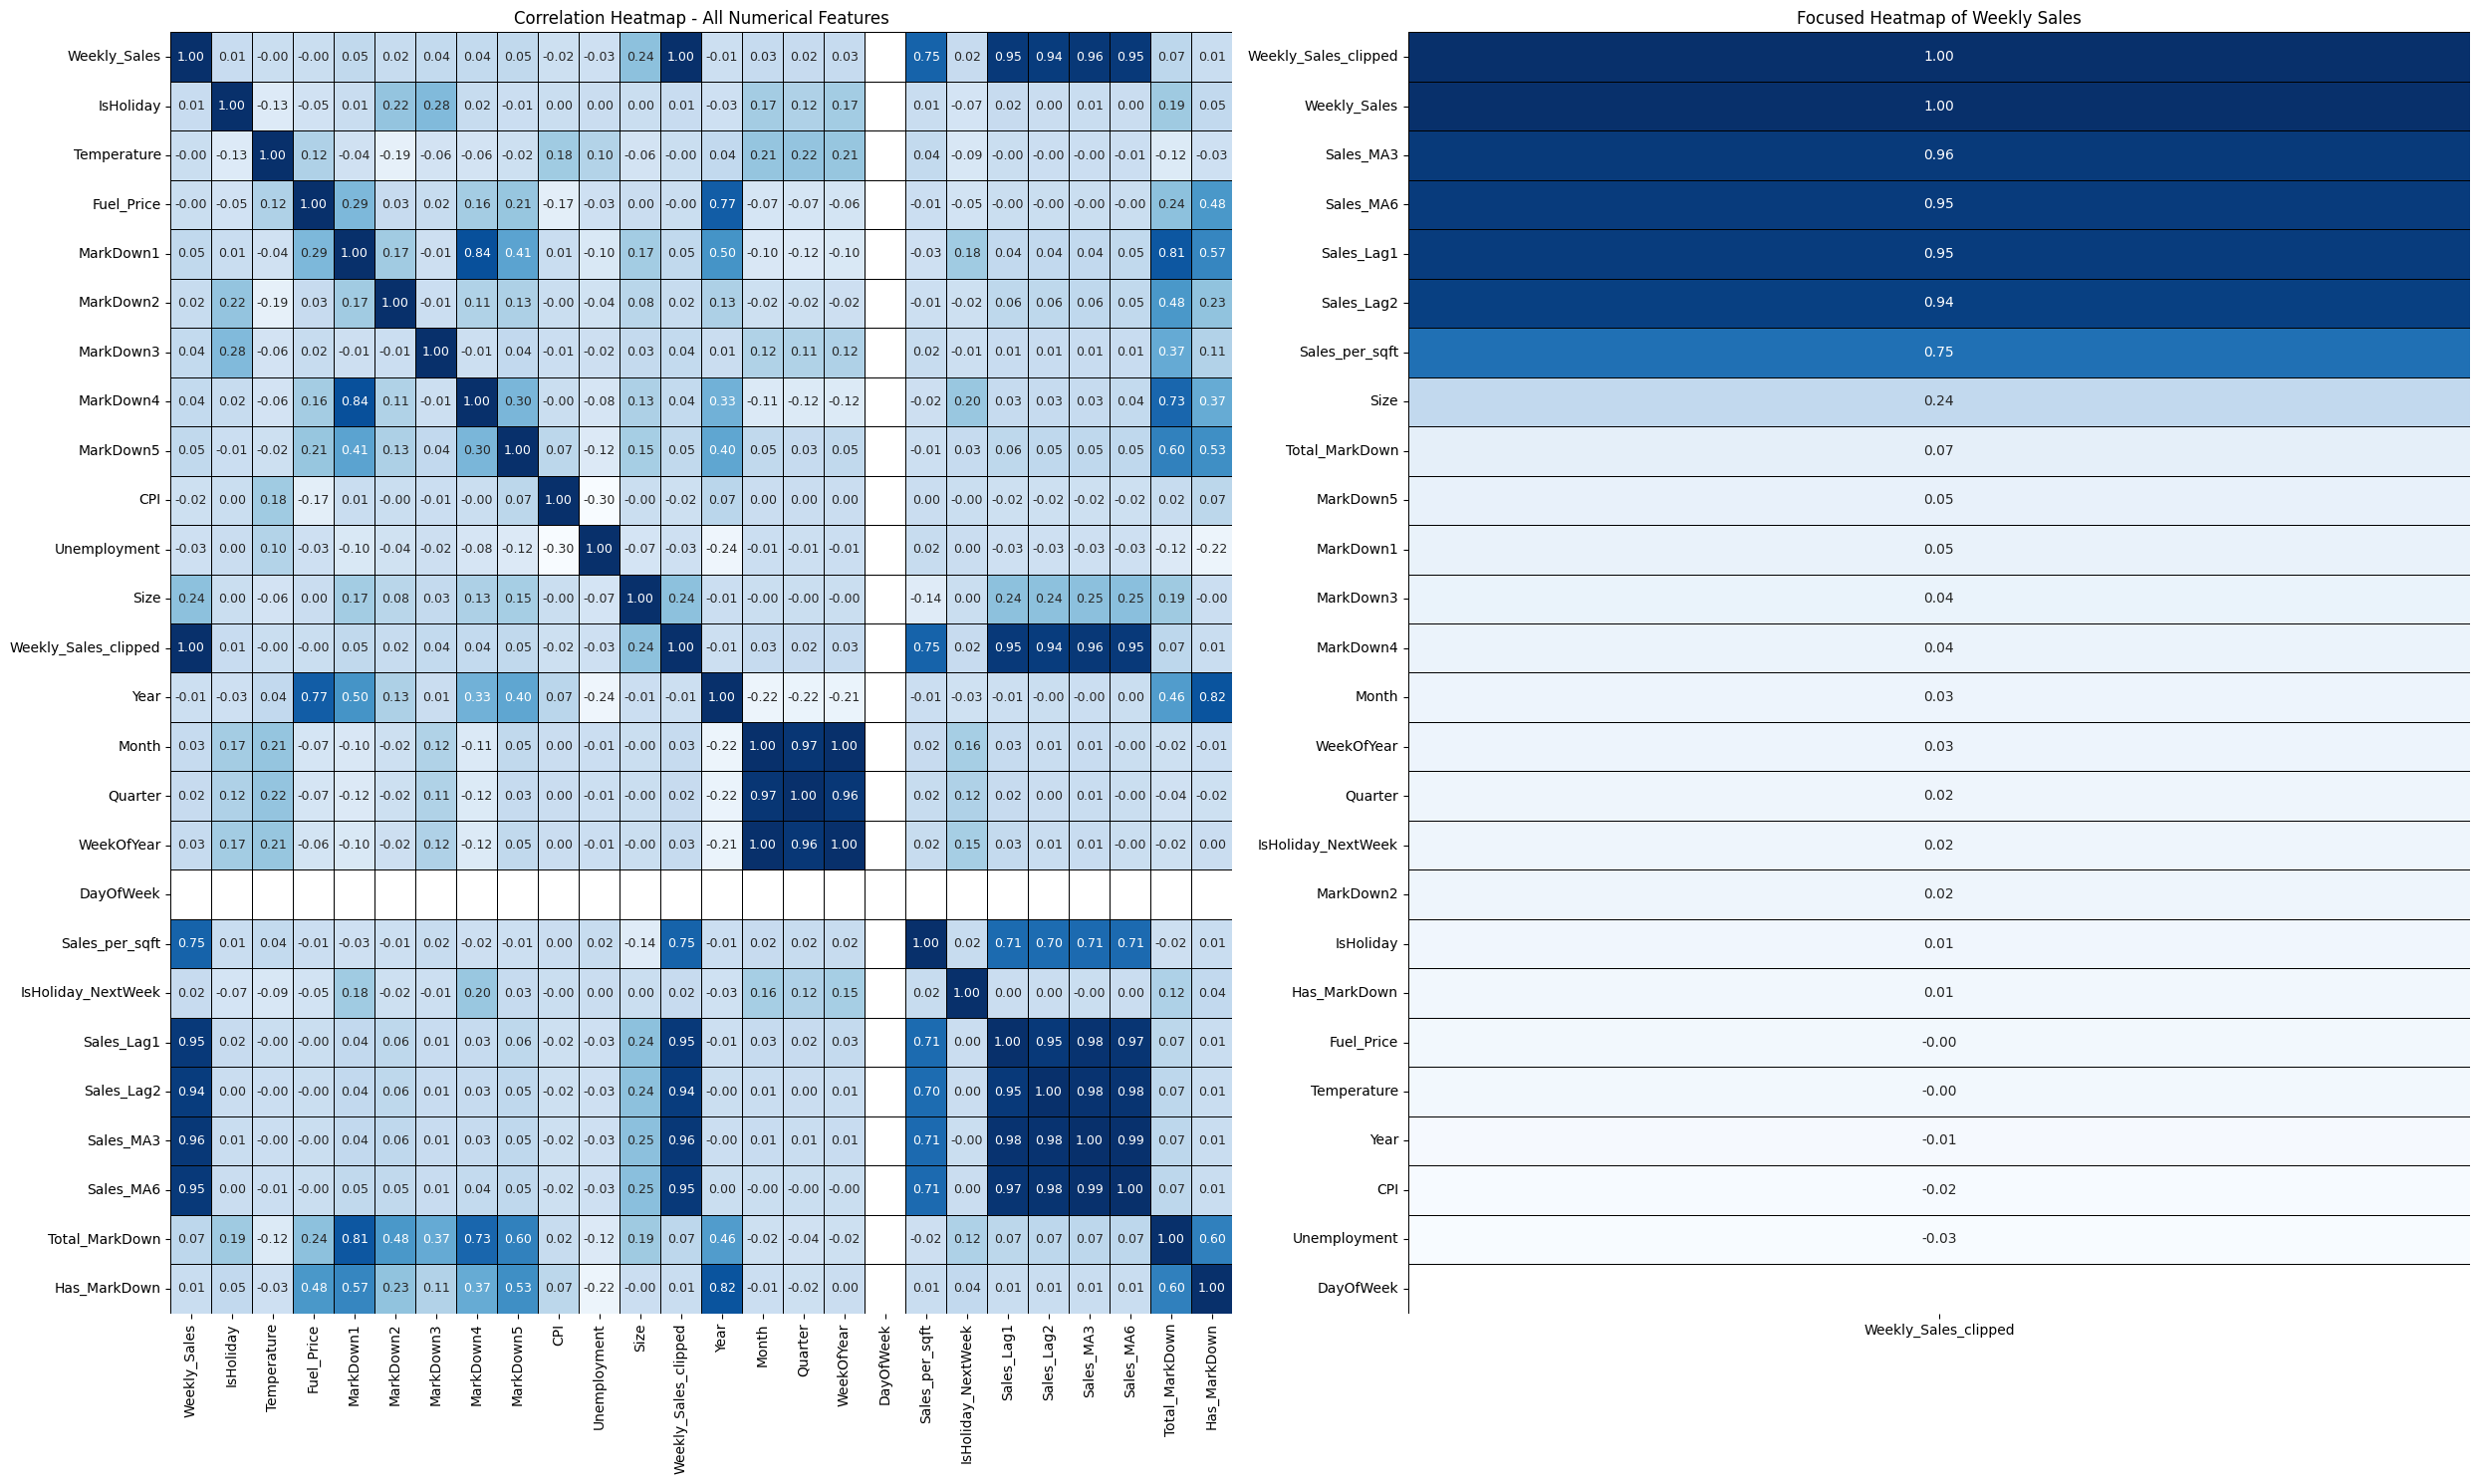

In [250]:
fig, axes = plt.subplots(1, 2, figsize=(25, 15))

# Correlation Heatmap (All Numeric Features)
corr = fe_data[num_features].corr()
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5, linecolor="black", annot_kws={"size": 9}, cbar=False, ax=axes[0])
axes[0].set_title("Correlation Heatmap - All Numerical Features")

# Focused Heatmap with Weekly_Sales_clipped
sales_corr = corr[['Weekly_Sales_clipped']].sort_values(by="Weekly_Sales_clipped", ascending=False)
sns.heatmap(sales_corr, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5, linecolor="black", cbar=False, ax=axes[1])
axes[1].set_title("Focused Heatmap of Weekly Sales")

plt.tight_layout()
plt.show()

- Top predictors of Weekly Sales are Sales_MA3 (0.96), Sales_MA6 (0.95), Sales_Lag1 (0.95), and Sales_Lag2 (0.94).
- Sales_per_sqft adds useful explanatory power (0.75 correlation).
- Calendar features (Month, Quarter, Week_Num) and promotions (MarkDowns) have low direct correlation, suggesting non-linear or seasonal effects.

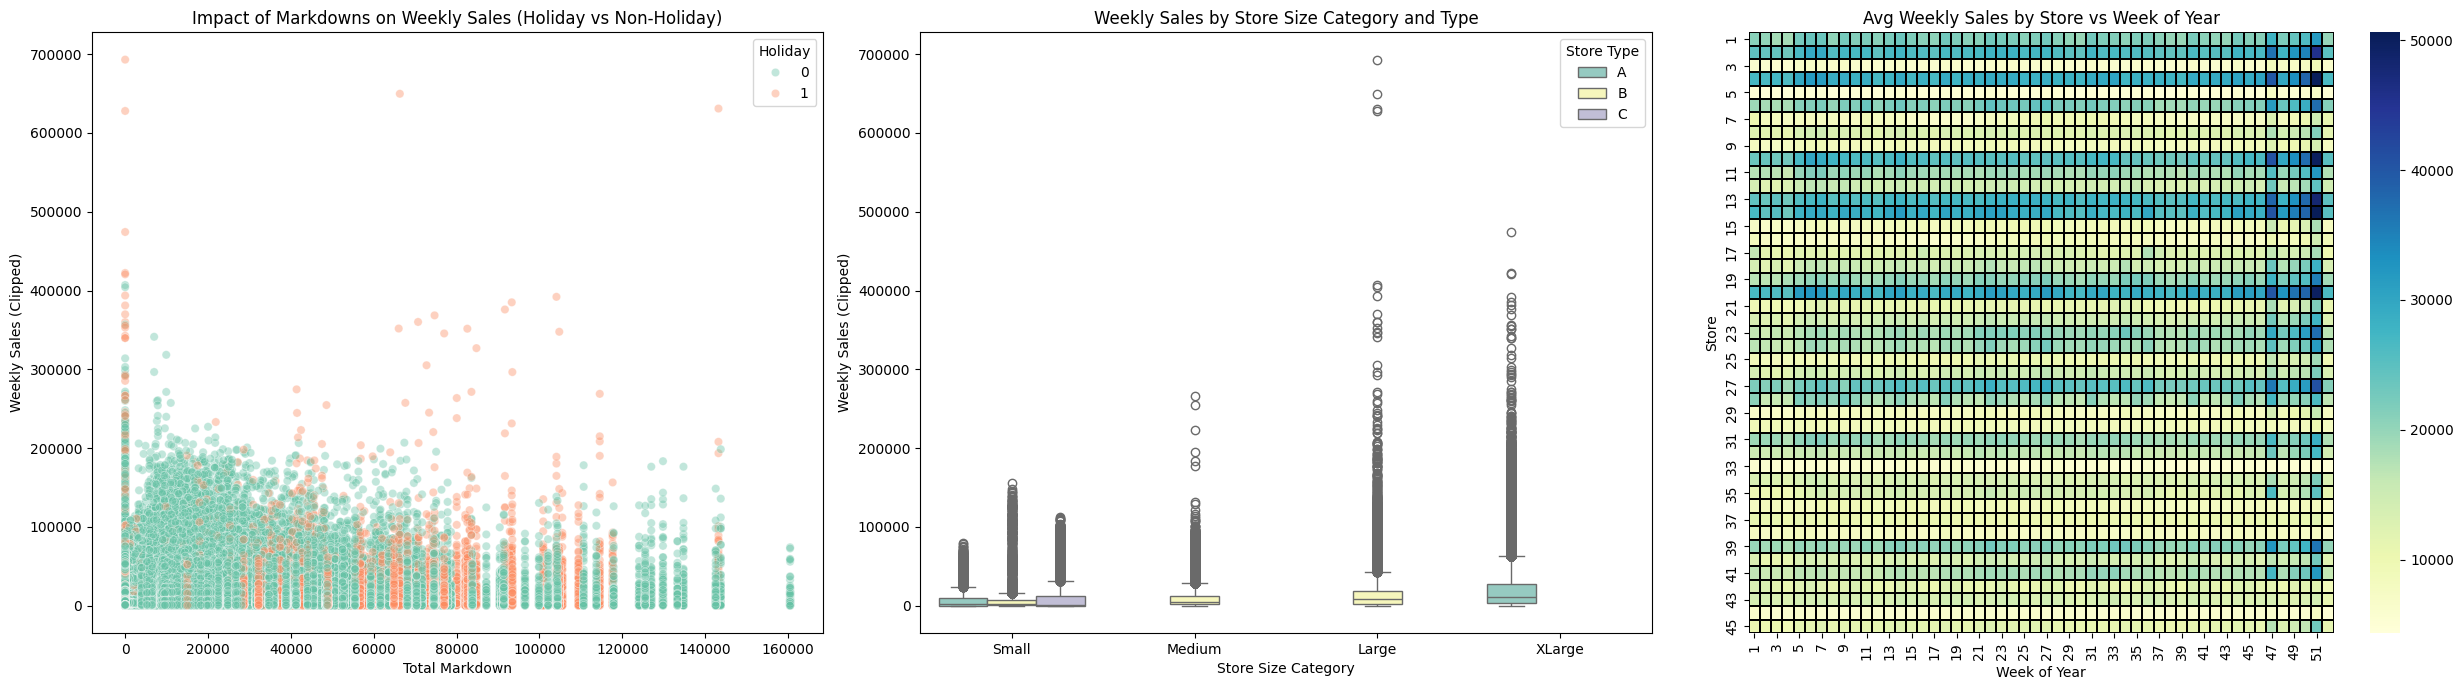

In [251]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

# 1. Holiday × Markdown Impact on Sales
sns.scatterplot(ax=axes[0], x="Total_MarkDown", y="Weekly_Sales_clipped", hue="IsHoliday", data=fe_data, alpha=0.4, palette="Set2")
axes[0].set_title("Impact of Markdowns on Weekly Sales (Holiday vs Non-Holiday)")
axes[0].set_xlabel("Total Markdown")
axes[0].set_ylabel("Weekly Sales (Clipped)")
axes[0].legend(title="Holiday")

# 2. Store Size × Type × Sales
sns.boxplot(ax=axes[1], x="Size_Category", y="Weekly_Sales_clipped", hue="Type", data=fe_data, palette="Set3")
axes[1].set_title("Weekly Sales by Store Size Category and Type")
axes[1].set_xlabel("Store Size Category")
axes[1].set_ylabel("Weekly Sales (Clipped)")
axes[1].legend(title="Store Type")

# 3. Heatmap of Stores vs Weeks
sales_matrix = fe_data.pivot_table(
    index="Store", columns="WeekOfYear",
    values="Weekly_Sales_clipped", aggfunc="mean", observed=False
)
sns.heatmap(sales_matrix, cmap="YlGnBu", ax=axes[2], cbar=True, linecolor="black", linewidths=0.3)
axes[2].set_title("Avg Weekly Sales by Store vs Week of Year")
axes[2].set_xlabel("Week of Year")
axes[2].set_ylabel("Store")

plt.tight_layout()
plt.show()

- ***Impact of Markdowns on Weekly Sales (Holiday vs Non-Holiday):*** Higher sales outliers are often associated with markdowns during holidays, though the relationship overall is weak.
- ***Weekly Sales by Store Size Category and Type:*** Larger stores (Large, XLarge) and Types A/B generally drive higher weekly sales compared to smaller stores.
- ***Avg Weekly Sales by Store vs Week of Year (Heatmap):*** Certain stores consistently outperform others, with seasonal peaks visible around holiday weeks.

### ***Segmentation & Clustering***

In [252]:
df = fe_data.copy()  
print("DATAFRAME shape:", df.shape)
print("Unique stores:", df['Store'].nunique(),"\nUnique depts:", df['Dept'].nunique())

DATAFRAME shape: (414945, 33)
Unique stores: 45 
Unique depts: 81


In [253]:
# Candidate features for store-level & dept-level segmentation 
candidate_features = [
    'Weekly_Sales_clipped',    # target / avg sales
    'Total_MarkDown',         # promotions
    'Sales_per_sqft',         # sales efficiency
    'Size',                   # store size
    'IsHoliday',              # holiday flag (we'll aggregate later)
    'CPI', 'Unemployment',    # economic indicators
    'Fuel_Price', 'Temperature',
    'Sales_Lag1', 'Sales_MA3' # basic time-series features
]

print("Selected features:", candidate_features)

Selected features: ['Weekly_Sales_clipped', 'Total_MarkDown', 'Sales_per_sqft', 'Size', 'IsHoliday', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature', 'Sales_Lag1', 'Sales_MA3']


In [254]:
display(df[candidate_features].describe().T)

count           mean           std        min  \
Weekly_Sales_clipped  414945.0   15999.941796  22702.869442      0.000   
Total_MarkDown        414945.0    6780.489147  14827.333391      0.000   
Sales_per_sqft        414945.0       0.129763      0.204061      0.000   
Size                  414945.0  136768.881837  60965.898747  34875.000   
IsHoliday             414945.0       0.064218      0.245141      0.000   
CPI                   414945.0     171.256550     39.171432    126.064   
Unemployment          414945.0       7.950904      1.863391      3.879   
Fuel_Price            414945.0       3.370836      0.454575      2.472   
Temperature           414945.0      60.479424     18.247346     -2.060   
Sales_Lag1            414945.0   16006.806664  22713.619823      0.000   
Sales_MA3             414945.0   16016.640395  22317.368541      0.000   

                               25%            50%            75%  \
Weekly_Sales_clipped   2100.000000    7631.190000   20236.420000   
Total_MarkDown            0.000000       0.000000    8310.810000   
Sales_per_sqft            0.017473       0.058968       0.161189   
Size                  93638.000000  140167.000000  202505.000000   
IsHoliday                 0.000000       0.000000       0.000000   
CPI                     132.106200     182.380600     212.592862   
Unemployment              6.891000       7.866000       8.567000   
Fuel_Price                2.942000       3.470000       3.742000   
Temperature              47.300000      62.540000      74.490000   
Sales_Lag1             2100.500000    7636.870000   20244.390000   
Sales_MA3              2150.636667    7725.603333   20317.670000   

                                max  
Weekly_Sales_clipped  693099.360000  
Total_MarkDown        160510.610000  
Sales_per_sqft             6.267013  
Size                  219622.000000  
IsHoliday                  1.000000  
CPI                      227.232807  
Unemployment              14.313000  
Fuel_Price                 4.468000  
Temperature              100.140000  
Sales_Lag1            693099.360000  
Sales_MA3             363033.780000

In [255]:
print("\nMissing values (selected features):")
print(df[candidate_features].isna().sum())


Missing values (selected features):
Weekly_Sales_clipped    0
Total_MarkDown          0
Sales_per_sqft          0
Size                    0
IsHoliday               0
CPI                     0
Unemployment            0
Fuel_Price              0
Temperature             0
Sales_Lag1              0
Sales_MA3               0
dtype: int64


In [256]:
# Store-level aggregation

# Group by Store and calculate aggregate stats
store_features = (
    df.groupby("Store", observed=True)
      .agg(
          avg_sales=("Weekly_Sales_clipped", "mean"),
          median_sales=("Weekly_Sales_clipped", "median"),
          total_sales=("Weekly_Sales_clipped", "sum"),
          avg_markdown=("Total_MarkDown", "mean"),
          holiday_sales=("Weekly_Sales_clipped", lambda x: df.loc[x.index, "IsHoliday"].dot(x) / max(df.loc[x.index, "IsHoliday"].sum(), 1)),
          avg_cpi=("CPI", "mean"),
          avg_unemp=("Unemployment", "mean"),
          avg_fuel=("Fuel_Price", "mean"),
          avg_temp=("Temperature", "mean"),
          sales_per_sqft=("Sales_per_sqft", "mean"),
          size=("Size", "mean")
      )
      .reset_index()
)

print("Aggregated store-level dataset shape:", store_features.shape)
display(store_features.head())

# Department level aggregation

# Group by Dept and calculate aggregate stats
dept_features = (
    df.groupby("Dept", observed=True)
    .agg(
        avg_sales=("Weekly_Sales_clipped", "mean"),
        median_sales=("Weekly_Sales_clipped", "median"),
        total_sales=("Weekly_Sales_clipped", "sum"),
        avg_markdown=("Total_MarkDown", "mean"),
        holiday_sales=("Weekly_Sales_clipped", lambda x: x[df.loc[x.index, "IsHoliday"] == 1].mean()),
        avg_cpi=("CPI", "mean"),
        avg_unemp=("Unemployment", "mean"),
        avg_fuel=("Fuel_Price", "mean"),
        avg_temp=("Temperature", "mean"),
        size=("Size", "mean"),  # avg store size serving this dept
        sales_per_sqft=("Sales_per_sqft", "mean")
        )
        .reset_index()
)

print("Aggregated Dept-level dataset shape:", dept_features.shape)
display(dept_features.head())

Aggregated store-level dataset shape: (45, 12)


Store     avg_sales  median_sales   total_sales  avg_markdown  \
0     1  21712.606482     10282.665  2.190802e+08   7435.126397   
1     2  26890.557737     14321.980  2.711106e+08  10184.505292   
2     3   6375.454394      2805.495  5.670329e+07   2499.722995   
3     4  29180.647178     15109.460  2.952206e+08   9833.370898   
4     5   5063.695574      2591.670  4.484409e+07   2966.281133   

   holiday_sales     avg_cpi  avg_unemp  avg_fuel   avg_temp  sales_per_sqft  \
0   23098.597108  216.067492   7.603570  3.228609  68.628976        0.143493   
1   28742.181048  215.725123   7.612687  3.229850  68.528345        0.132920   
2    6954.976344  219.477707   7.172502  3.228996  71.663462        0.170503   
3   31093.340783  128.713171   5.926123  3.225717  62.569954        0.141748   
4    5728.210052  216.651070   6.292309  3.231083  69.640874        0.145196   

       size  
0  151315.0  
1  202307.0  
2   37392.0  
3  205863.0  
4   34875.0

Aggregated Dept-level dataset shape: (81, 12)


Dept     avg_sales  median_sales   total_sales  avg_markdown  holiday_sales  \
0    1  19117.377578      15231.28  1.212998e+08   6356.657721   18296.262642   
1    2  43620.823447      41436.16  2.767741e+08   6356.657721   42351.237407   
2    3  11816.980304       9240.08  7.497874e+07   6356.657721   12473.564494   
3    4  25983.587422      24282.47  1.648659e+08   6356.657721   26989.479877   
4    5  21310.889850      17926.30  1.333422e+08   6446.059332   32998.076550   

      avg_cpi  avg_unemp  avg_fuel   avg_temp           size  sales_per_sqft  
0  171.632297   7.990354  3.367865  61.040654  130287.600000        0.158627  
1  171.632297   7.990354  3.367865  61.040654  130287.600000        0.347075  
2  171.632297   7.990354  3.367865  61.040654  130287.600000        0.087078  
3  171.632297   7.990354  3.367865  61.040654  130287.600000        0.217612  
4  171.157290   7.968848  3.374868  60.934507  131548.233658        0.152526

In [257]:
# Features for clustering (exclude 'Store' column itself)
clustering_store = [c for c in store_features.columns if c not in ["Store"]]
print("Clustering features for store:", clustering_store)

# Features for clustering (exclude 'Dept' column itself)
clustering_dept = [c for c in dept_features.columns if c not in ["Dept"]]
print("Clustering features for dept:", clustering_dept)

Clustering features for store: ['avg_sales', 'median_sales', 'total_sales', 'avg_markdown', 'holiday_sales', 'avg_cpi', 'avg_unemp', 'avg_fuel', 'avg_temp', 'sales_per_sqft', 'size']
Clustering features for dept: ['avg_sales', 'median_sales', 'total_sales', 'avg_markdown', 'holiday_sales', 'avg_cpi', 'avg_unemp', 'avg_fuel', 'avg_temp', 'size', 'sales_per_sqft']


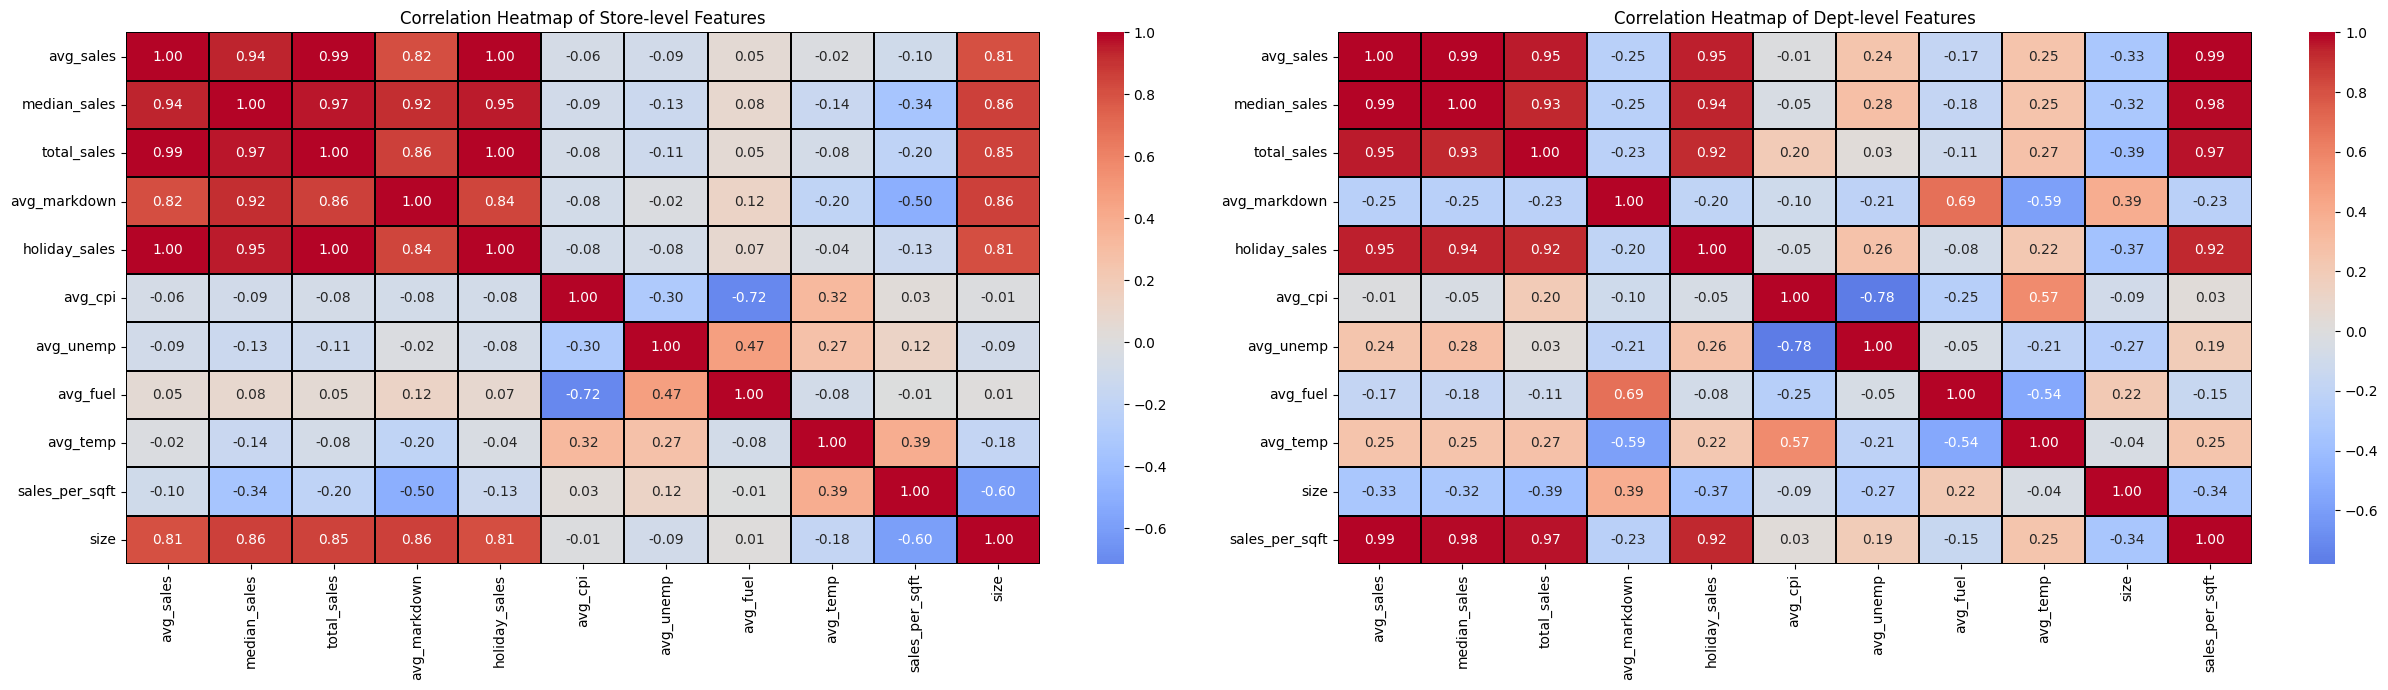

In [258]:
# Correlation heatmaps inspect redundancy
fig, axes = plt.subplots(1, 2, figsize=(25, 7))

# Store features
sns.heatmap(store_features[clustering_store].corr(), cmap="coolwarm", center=0, annot=True, fmt=".2f", linecolor="black", linewidths=0.3, ax=axes[0])
axes[0].set_title("Correlation Heatmap of Store-level Features")

# Dept features
sns.heatmap(dept_features[clustering_dept].corr(), cmap="coolwarm", center=0, annot=True, fmt=".2f", linecolor="black", linewidths=0.3, ax=axes[1])
axes[1].set_title("Correlation Heatmap of Dept-level Features")

plt.tight_layout()
plt.show()

In [259]:
# Feature Selection - leave out redundant features
cluster_store = store_features[["avg_sales", "avg_markdown", "size", "avg_cpi", "avg_unemp", "avg_fuel", "avg_temp"]].copy()
cluster_dept = dept_features[["avg_sales", "avg_markdown", "size", "avg_cpi", "avg_unemp", "avg_fuel", "avg_temp"]].copy()

# Scaling
s_scaler = StandardScaler()
X_store_scaled = s_scaler.fit_transform(cluster_store)

d_scaler = StandardScaler()
X_dept_scaled = d_scaler.fit_transform(cluster_dept)

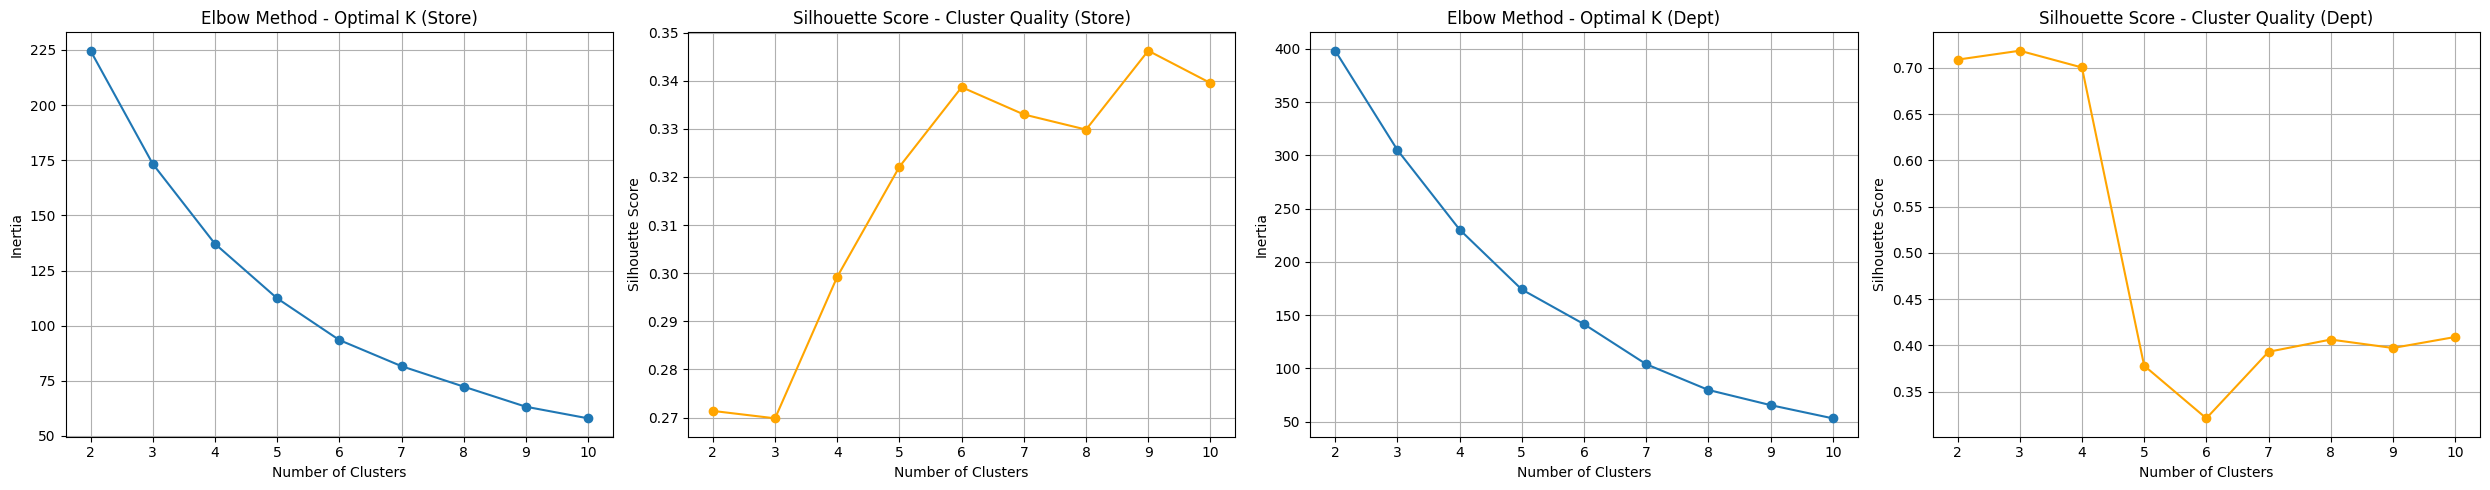

In [260]:
# Elbow & Silhouette score methods to find best k value
inertia_store, inertia_dept = [], []
silhouette_scores_store, silhouette_scores_dept = [], []
K_range = range(2, 11)

for k in K_range:
    km_s = KMeans(n_clusters=k, random_state=42, n_init=10)
    km_s.fit(X_store_scaled)
    inertia_store.append(km_s.inertia_)
    silhouette_scores_store.append(silhouette_score(X_store_scaled, km_s.labels_))

    km_d = KMeans(n_clusters=k, random_state=42, n_init=10)
    km_d.fit(X_dept_scaled)
    inertia_dept.append(km_d.inertia_)
    silhouette_scores_dept.append(silhouette_score(X_dept_scaled, km_d.labels_))

# Plot side-by-side
fig, axes = plt.subplots(1, 4, figsize=(25, 5))

# Elbow Method
axes[0].plot(K_range, inertia_store, marker='o')
axes[0].set_title("Elbow Method - Optimal K (Store)")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Inertia")
axes[0].grid(True)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores_store, marker='o', color='orange')
axes[1].set_title("Silhouette Score - Cluster Quality (Store)")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhouette Score")
axes[1].grid(True)

# Elbow Method
axes[2].plot(K_range, inertia_dept, marker='o')
axes[2].set_title("Elbow Method - Optimal K (Dept)")
axes[2].set_xlabel("Number of Clusters")
axes[2].set_ylabel("Inertia")
axes[2].grid(True)

# Silhouette Score
axes[3].plot(K_range, silhouette_scores_dept, marker='o', color='orange')
axes[3].set_title("Silhouette Score - Cluster Quality (Dept)")
axes[3].set_xlabel("Number of Clusters")
axes[3].set_ylabel("Silhouette Score")
axes[3].grid(True)

plt.tight_layout()
plt.show()

#### ***Store-level Clustering:***
- ***Elbow plot:*** clear bend between k=4 and k=6.
- ***Silhouette score:*** peak around k=9 (≈0.35), but scores are stable after k=5.
- ***➡️ Best tradeoff: k = 5 or 6 (captures diversity without over-fragmenting).***

#### ***Dept-level Clustering:***
- ***Elbow plot:*** bend around k=3–4.
- ***Silhouette score:*** very high at k=2–4 (0.70+ at k=2, ~0.71 at k=3, ~0.70 at k=4), but drops sharply after k=5.
- ***➡️ Best choice: k = 3 (balances compact clusters + high separation).***

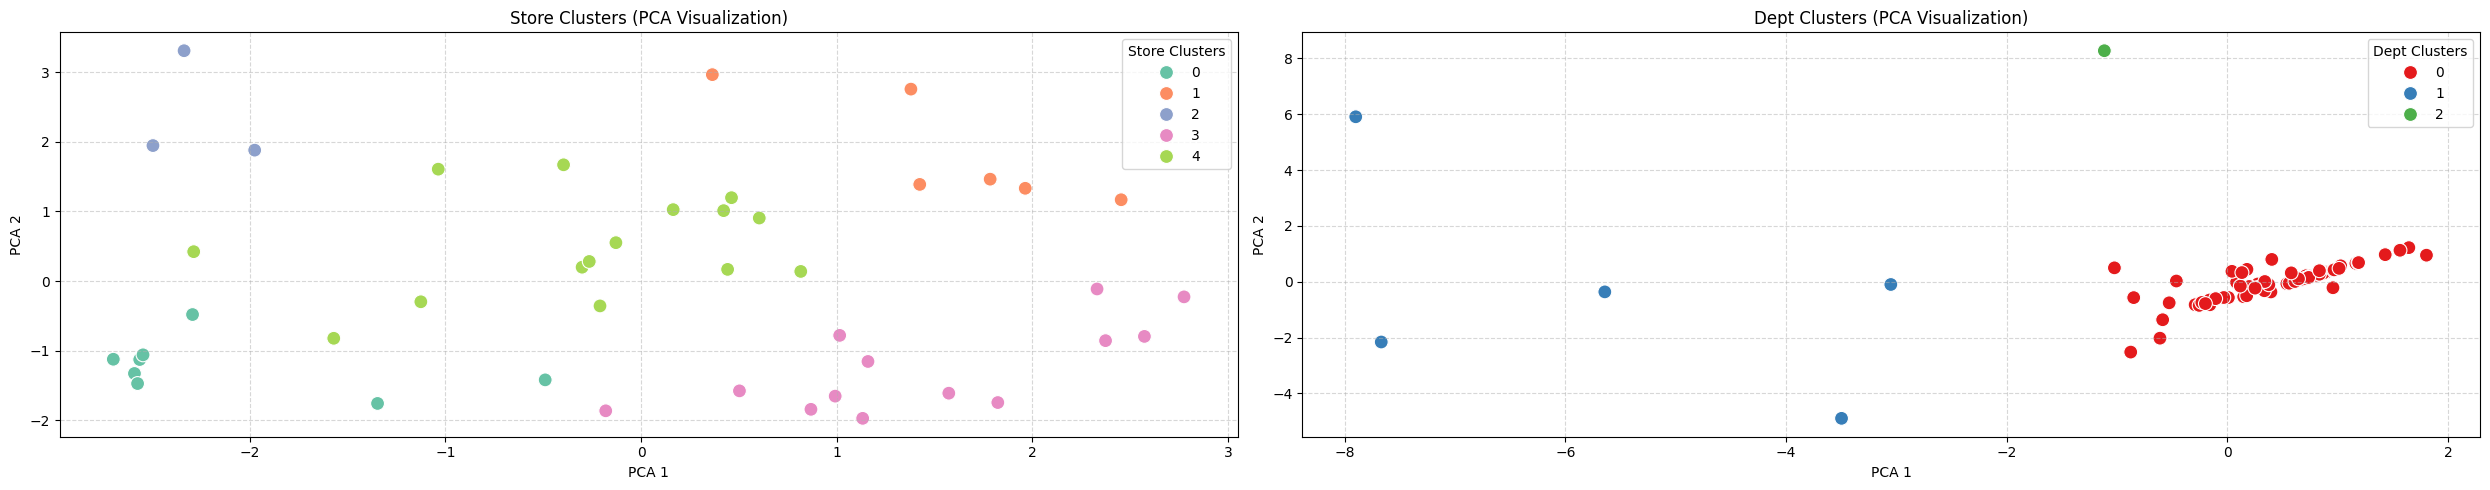

In [261]:
# Fitting best k for store
optimal_k_store = 5
kmeans_s = KMeans(n_clusters=optimal_k_store, random_state=42, n_init=10)
store_features["Cluster"] = kmeans_s.fit_predict(X_store_scaled)

# Fitting best k for dept
optimal_k_dept = 3
kmeans_d = KMeans(n_clusters=optimal_k_dept, random_state=42, n_init=10)
dept_features["Cluster"] = kmeans_d.fit_predict(X_dept_scaled)

# PCA Visualization
fig, axes = plt.subplots(1, 2, figsize=(25, 5))

# Store
pca_store = PCA(n_components=2)
X_pca_s = pca_store.fit_transform(X_store_scaled)
sns.scatterplot(x=X_pca_s[:,0], y=X_pca_s[:,1], hue=store_features["Cluster"], palette="Set2", s=100, ax=axes[0])
axes[0].set_title("Store Clusters (PCA Visualization)")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")
axes[0].legend(title="Store Clusters")
axes[0].grid(True, linestyle="--", alpha=0.5)

pca_dept = PCA(n_components=2)
X_pca_d = pca_dept.fit_transform(X_dept_scaled)
sns.scatterplot(x=X_pca_d[:,0], y=X_pca_d[:,1], hue=dept_features["Cluster"], palette="Set1", s=100, ax=axes[1])
axes[1].set_title("Dept Clusters (PCA Visualization)")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")
axes[1].legend(title="Dept Clusters")
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Store Clustering - Homogeneity: 0.45, Completeness: 0.30


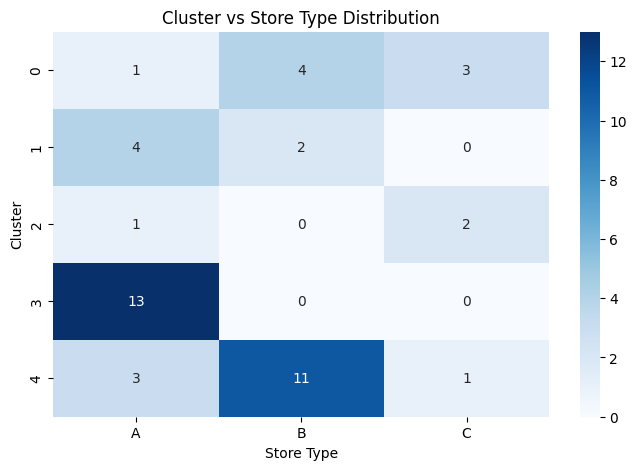

In [262]:
# Merge Type back
store_features = store_features.merge(
    df[["Store", "Type"]].drop_duplicates(),
    on="Store", how="left"
)

hom = homogeneity_score(store_features["Type"], store_features["Cluster"])
comp = completeness_score(store_features["Type"], store_features["Cluster"])

print(f"Store Clustering - Homogeneity: {hom:.2f}, Completeness: {comp:.2f}")

# Plot cross-tabulation of Cluster vs Store Type
plt.figure(figsize=(8,5))
sns.heatmap(pd.crosstab(store_features["Cluster"], store_features["Type"]),
            annot=True, fmt="d", cmap="Blues")
plt.title("Cluster vs Store Type Distribution")
plt.ylabel("Cluster")
plt.xlabel("Store Type")
plt.show()

***Cluster Evaluation (vs. Store Type)***

- ***Homogeneity = 0.45*** → Clusters contain mixed Store Types.  
- ***Completeness = 0.30*** → Stores of the same Type are spread across clusters.  
- ***Interpretation:*** Clustering reveals **behavioral patterns that go beyond the simple A/B/C store classification**.  
- Some Type B stores behave more like Type A (e.g., high sales but low markdown dependency), showing that the official classification alone is not enough for strategy.


In [263]:
# --- Store Cluster Profiles ---
store_profiles = store_features.groupby("Cluster")[cluster_store.columns].mean().round(2)
print("Store Cluster Profiles (Averages per Cluster):")
display(store_profiles)

# --- Dept Cluster Profiles ---
dept_profiles = dept_features.groupby("Cluster")[cluster_dept.columns].mean().round(2)
print("Department Cluster Profiles (Averages per Cluster):")
display(dept_profiles)

Store Cluster Profiles (Averages per Cluster):


avg_sales  avg_markdown       size  avg_cpi  avg_unemp  avg_fuel  \
Cluster                                                                     
0          9087.65       2375.93   62767.12   215.63       7.55      3.23   
1         20676.19       9702.34  176145.67   132.58       9.83      3.60   
2          8253.40        761.64   39690.00   128.77       9.95      3.61   
3         22535.89       9299.55  195078.15   196.87       7.31      3.27   
4         12062.22       5837.14  109923.00   150.55       7.67      3.39   

         avg_temp  
Cluster            
0           70.02  
1           63.03  
2           73.43  
3           62.73  
4           51.42

Department Cluster Profiles (Averages per Cluster):


avg_sales  avg_markdown       size  avg_cpi  avg_unemp  avg_fuel  \
Cluster                                                                     
0         14502.56       6811.92  138618.66   171.08       7.94      3.37   
1           671.30      16576.84  163598.42   158.50       7.96      3.66   
2         45512.82       4981.94  158114.00   128.71       9.94      3.23   

         avg_temp  
Cluster            
0           60.34  
1           52.06  
2           58.82

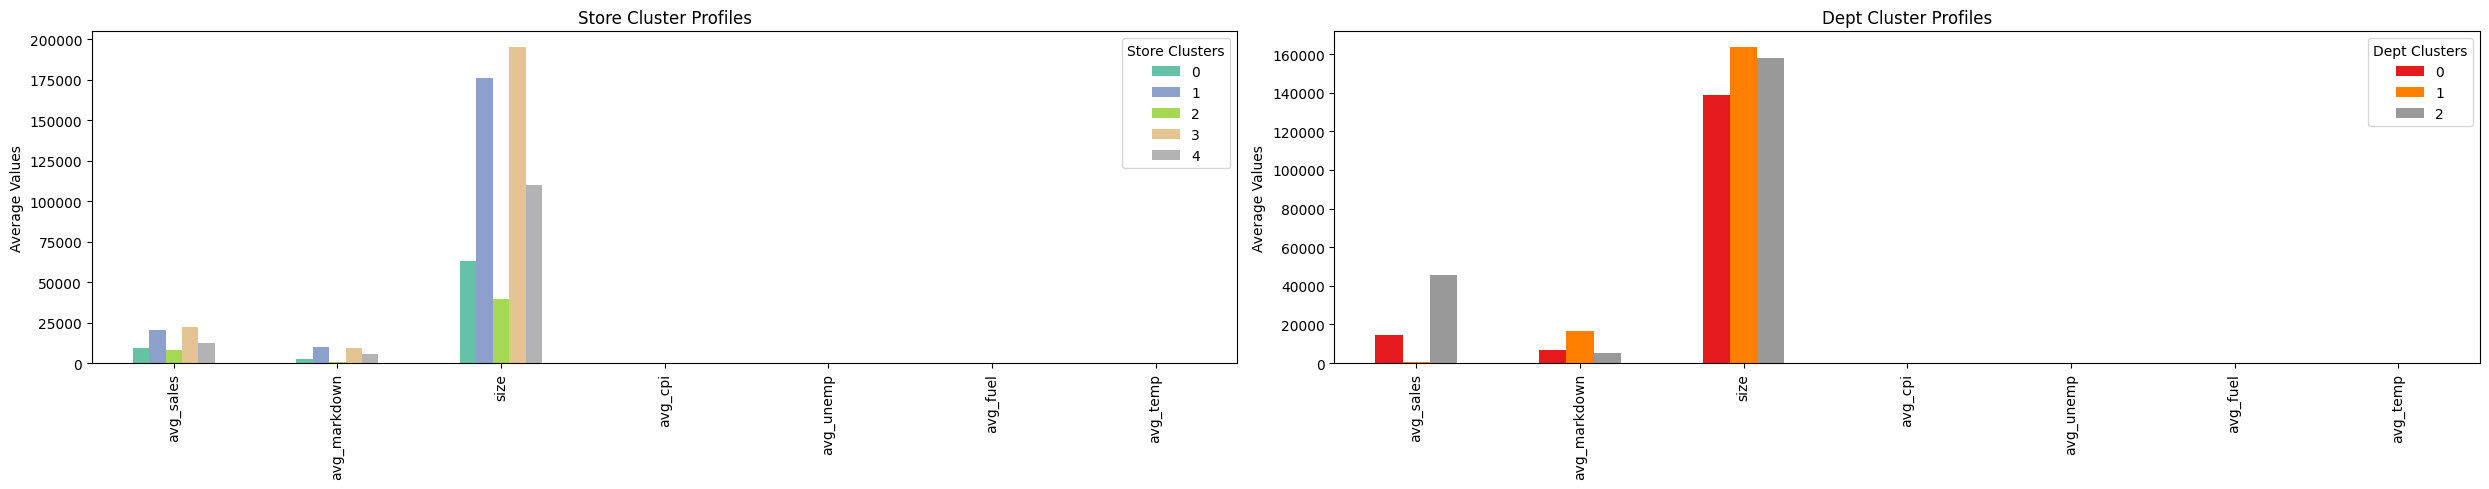

In [264]:
# Plot Profiles
fig, axes = plt.subplots(1, 2, figsize=(25, 5))

# Store Profiles
store_profiles.T.plot(kind="bar", ax=axes[0], colormap="Set2")
axes[0].set_title("Store Cluster Profiles")
axes[0].set_ylabel("Average Values")
axes[0].legend(title="Store Clusters")

# Dept Profiles
dept_profiles.T.plot(kind="bar", ax=axes[1], colormap="Set1")
axes[1].set_title("Dept Cluster Profiles")
axes[1].set_ylabel("Average Values")
axes[1].legend(title="Dept Clusters")

plt.tight_layout()
plt.show()

#### ***Store Clusters – Insights with Personalized Marketing & Inventory Strategies***

**Cluster 0 (Small, low-sales stores)**
- Low avg. sales (~9K) and markdowns (~2K).
- Small store size (~62K).
- Likely underperforming or niche-format stores.  
- ***Marketing:*** Targeted promotions to build local loyalty.
- ***Inventory:*** Rationalize assortment, avoid overstocking slow movers.

**Cluster 1 (Large markdown-driven stores)**
- High avg. sales (~20K) with heavy markdowns (~9.7K).
- Very large store size (~176K).
- Heavy dependency on promotions.  
- ***Marketing:*** Launch **premium product campaigns** and loyalty programs.
- ***Inventory:*** Prioritize stock availability for high-margin items and fast-moving categories.

**Cluster 2 (Tiny stores with minimal markdowns)**
- Very low avg. sales (~8K), very low markdowns (~761).
- Very small store size (~39K).  
- ***Marketing:*** Focus on **convenience-driven offers** (grab-and-go, bundles).
- ***Inventory:*** Localized SKU optimization, fast-turnover essentials.

**Cluster 3 (High-performing large stores)**
- Highest avg. sales (~22.5K) and large size (~195K).
- Strong markdown usage (~9.3K).  
- ***Marketing:*** Launch **premium product campaigns** and loyalty programs.
- ***Inventory:*** Prioritize stock availability for high-margin items and fast-moving categories.

**Cluster 4 (Mid-size, stable performers)**
- Moderate avg. sales (~12K), markdowns (~5.8K).
- Mid-size stores (~109K).
- Balanced profile.  
- ***Marketing:*** Maintain **steady promotions** with localized campaigns.
- ***Inventory:*** Focus on **efficient replenishment** and cost control.
  
#### ***Department Clusters – Insights and Personalized Marketing & Inventory Strategies***

**Cluster 0 (Balanced departments)**
- Avg. sales ~14.5K, markdowns ~6.8K.
- Size ~138K.
- Moderate performers.  
- ***Marketing:*** Regular markdowns and bundled offers to sustain sales.
- ***Inventory:*** Maintain steady stocking aligned with forecast demand.
  
**Cluster 1 (Low-sales, markdown-heavy departments)**
- Very low avg. sales (~671) but high markdowns (~16.5K).
- Likely clearance or slow-moving categories.  
- ***Marketing:*** Regular markdowns and bundled offers to sustain sales.
- ***Inventory:*** Maintain steady stocking aligned with forecast demand.

**Cluster 2 (Star departments)**
- Very high avg. sales (~45.5K) with moderate markdowns (~4.9K).
- Strongest performing departments.  
- ***Marketing:*** Aggressive cross-selling campaigns with complementary categories.
- ***Inventory:*** Ensure **zero stockouts** to avoid lost revenue opportunities.

#### ***Business Interpretation***

**Store Level**
- Clustering does **not strictly align with Store Type (A/B/C)** — Homogeneity = 0.45, Completeness = 0.30. This indicates that clustering reveals **hidden behavioral patterns** beyond the simple classification.  
- Segmentation shows clear groups of **growth drivers (Clusters 3 & 1)**, **steady performers (Cluster 4 & 0)**, and **niche/express formats (Cluster 2)**.  
- **Markdown reliance is high** in Clusters 1 and 3. These clusters drive most sales but are promotion-dependent — profitability and ROI of markdowns should be carefully monitored.  
- **Cluster 2 (tiny stores)** may represent express/niche formats. Though currently low in sales, they could be leveraged for **localized strategies** (convenience products, fast replenishment, or digital-first integration).  

**Department Level**
- **Cluster 2 (Star departments):** Sales engines that contribute disproportionately to revenue. They should be prioritized for inventory stocking, availability, and cross-selling opportunities.  
- **Cluster 0 (Balanced departments):** Moderate performers that respond steadily to promotions. Regular markdowns can help sustain performance.  
- **Cluster 1 (Low-sales, markdown-heavy departments):** High promotional costs but low revenue contribution. These drag down profitability and need **SKU rationalization, repricing, or repositioning**.  

**Overall Takeaway**
- Clustering provides a richer view of store and department performance than the simple Store Type classification.  
- By combining these insights with demand forecasting, the business can **align inventory planning, optimize markdown calendars, and tailor marketing strategies** to cluster-specific needs.  
- This segmentation can directly support **profitability improvement, customer experience personalization, and store-level optimization.**

### ***Market Basket Analysis (MBA)***

In [265]:
# Prepare transaction data (Dept-Level Baskets)
basket = merged_df.groupby(['Store', 'Date', 'Dept'], observed=True)['Weekly_Sales'].sum().unstack().fillna(0)

# Focus on top departments by total sales to reduce noise
top_depts = merged_df.groupby("Dept", observed=True)["Weekly_Sales"].sum().nlargest(50).index
basket = basket[top_depts]

In [266]:
# Encode purchases as Boolean (threshold ensures very small sales aren’t counted as purchases)
basket_encoded = (basket > 1000).astype(bool)
basket_encoded

Dept                92    95    38    72    90    40     2    91    13     8  \
Store Date                                                                     
1     2010-02-05  True  True  True  True  True  True  True  True  True  True   
      2010-02-12  True  True  True  True  True  True  True  True  True  True   
      2010-02-19  True  True  True  True  True  True  True  True  True  True   
      2010-02-26  True  True  True  True  True  True  True  True  True  True   
      2010-03-05  True  True  True  True  True  True  True  True  True  True   
...                ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
45    2012-09-28  True  True  True  True  True  True  True  True  True  True   
      2012-10-05  True  True  True  True  True  True  True  True  True  True   
      2012-10-12  True  True  True  True  True  True  True  True  True  True   
      2012-10-19  True  True  True  True  True  True  True  True  True  True   
      2012-10-26  True  True  True  True  True  True  True  True  True  True   

Dept              ...     98     18     49    33    24    20    42    21  \
Store Date        ...                                                      
1     2010-02-05  ...   True   True   True  True  True  True  True  True   
      2010-02-12  ...   True   True   True  True  True  True  True  True   
      2010-02-19  ...   True   True   True  True  True  True  True  True   
      2010-02-26  ...   True  False   True  True  True  True  True  True   
      2010-03-05  ...   True  False   True  True  True  True  True  True   
...               ...    ...    ...    ...   ...   ...   ...   ...   ...   
45    2012-09-28  ...  False   True  False  True  True  True  True  True   
      2012-10-05  ...  False   True  False  True  True  True  True  True   
      2012-10-12  ...   True   True  False  True  True  True  True  True   
      2012-10-19  ...  False   True  False  True  True  True  True  True   
      2012-10-26  ...   True   True  False  True  True  True  True  True   

Dept                71    29  
Store Date                    
1     2010-02-05  True  True  
      2010-02-12  True  True  
      2010-02-19  True  True  
      2010-02-26  True  True  
      2010-03-05  True  True  
...                ...   ...  
45    2012-09-28  True  True  
      2012-10-05  True  True  
      2012-10-12  True  True  
      2012-10-19  True  True  
      2012-10-26  True  True  

[6435 rows x 50 columns]

In [267]:
# FP Growth
freq_items = fpgrowth(basket_encoded, min_support=0.05, use_colnames=True, max_len=2)  # dept pairs with >=5% support
print("Number of frequent itemsets:", len(freq_items))

# Association Rules
rules = association_rules(freq_items, metric="lift", min_threshold=1)
rules = rules[rules['confidence'] > 0.5]  # keep strong rules
rules = rules.sort_values(by="lift", ascending=False)

print("\nTop Cross-Selling Opportunities (Dept-Level):")
display(rules[['antecedents','consequents','support','confidence','lift']].head(15))

Number of frequent itemsets: 1275

Top Cross-Selling Opportunities (Dept-Level):


antecedents consequents   support  confidence      lift
1734        (80)        (98)  0.623155    0.941757  1.459235
1735        (98)        (80)  0.623155    0.965567  1.459235
1731        (94)        (98)  0.641647    0.918985  1.423951
1730        (98)        (94)  0.641647    0.994221  1.423951
1697        (94)        (80)  0.631857    0.904963  1.367646
1696        (80)        (94)  0.631857    0.954908  1.367646
1817        (71)        (49)  0.554468    0.707796  1.274746
1816        (49)        (71)  0.554468    0.998601  1.274746
1694        (80)        (93)  0.661383    0.999530  1.247958
1695        (93)        (80)  0.661383    0.825766  1.247958
1914        (49)        (18)  0.285315    0.513854  1.245443
1915        (18)        (49)  0.285315    0.691525  1.245443
1733        (93)        (98)  0.636364    0.794529  1.231108
1732        (98)        (93)  0.636364    0.986034  1.231108
1739        (29)        (49)  0.555245    0.682913  1.229931

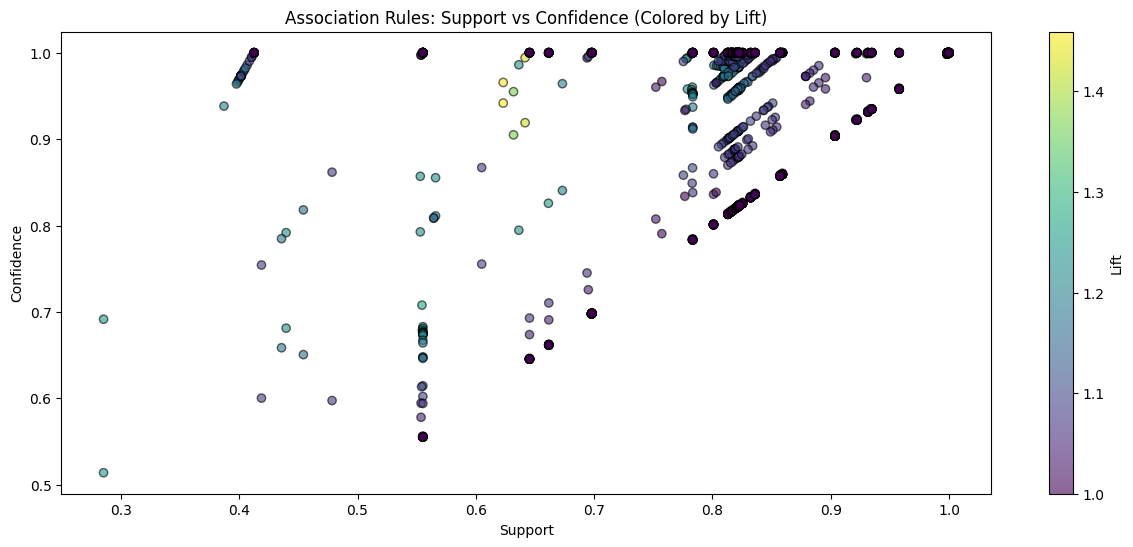

In [268]:
# Visualize – Rule Strength Scatterplot (Support vs Confidence)
# Shows the distribution of rules and highlights which ones are both frequent (support) and strong (confidence, lift).
plt.figure(figsize=(15,6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.6, c=rules['lift'], cmap="viridis", edgecolors="k")
plt.colorbar(label="Lift")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Association Rules: Support vs Confidence (Colored by Lift)")
plt.show()

***Association Rules – Support vs Confidence (Lift as Color)***

- Each point represents an association rule between two departments.  
- **X-axis (Support):** How frequently the rule occurs in all transactions.  
- **Y-axis (Confidence):** How often the consequent appears when the antecedent is present.  
- **Color (Lift):** Strength of association (Lift > 1 means stronger-than-random co-occurrence).  

***Observations*:**
- Many rules have **very high confidence (>0.9)**, showing strong predictive power once a department is purchased.  
- Rules with **high support (>0.6)** represent broad shopping patterns that apply to a large share of transactions.  
- A few rules stand out with **Lift ~1.4+**, indicating exceptionally strong co-purchase opportunities.  
- These high-lift, high-confidence rules are ideal candidates for **cross-selling promotions and recommendation systems**.  


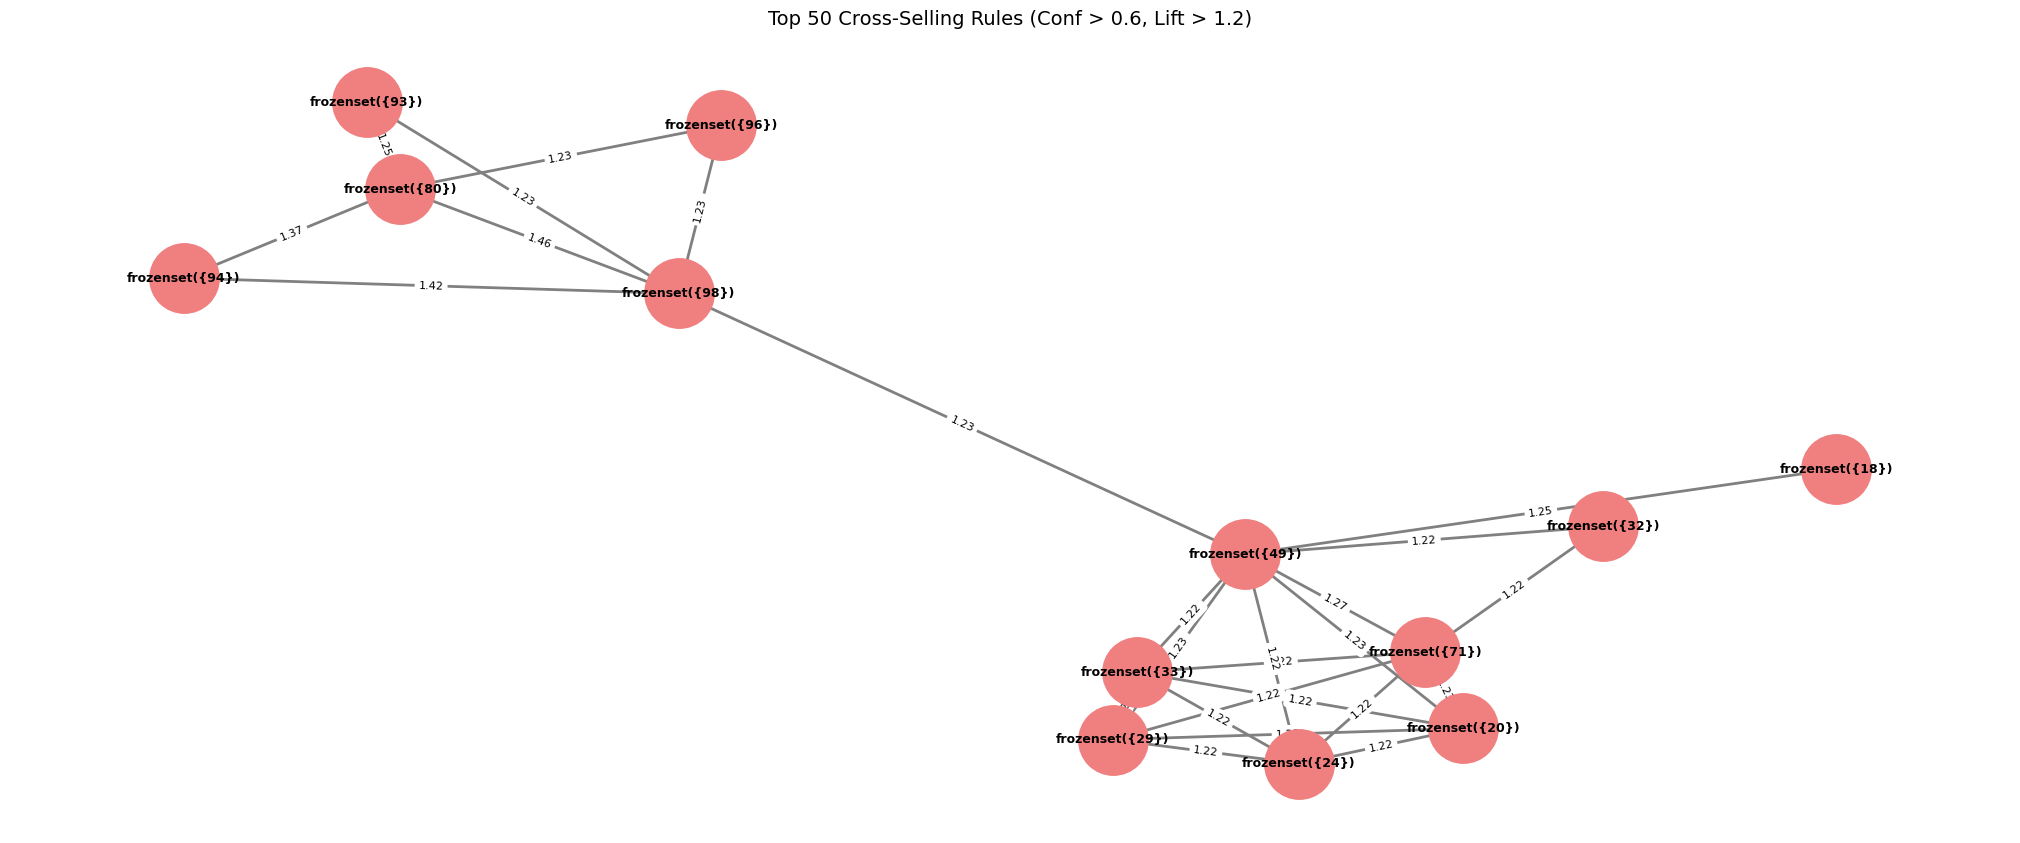

In [269]:
# Build a network graph that only shows strong rules with confidence > 0.6 and lift > 1.2
strong_rules = rules[(rules['confidence'] > 0.6) & (rules['lift'] > 1.2)].head(50)
G = nx.from_pandas_edgelist(strong_rules, 'antecedents', 'consequents', ['lift'])

plt.figure(figsize=(20,8))
pos = nx.spring_layout(G, k=0.6, seed=42)

nx.draw(G, pos, with_labels=True, node_size=2500, node_color="lightcoral", font_size=9, font_weight="bold", edge_color="gray", width=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(i,j): f"{d['lift']:.2f}" for i,j,d in G.edges(data=True)}, font_size=8)

plt.title("Top 50 Cross-Selling Rules (Conf > 0.6, Lift > 1.2)", fontsize=14)
plt.show()

#### ***Market Basket Analysis – Department-Level Insights***

The cross-selling network graph (Confidence > 0.6, Lift > 1.2) highlights strong co-purchase patterns between departments.  
Nodes represent **Departments**, edges represent **associations**, and edge labels indicate **Lift (strength of association)**.

#### ***Key Inferences***

1. **Cluster of Highly Associated Departments (Dept 49, 20, 24, 29, 32, 33, 71)**
   - These departments frequently co-occur in transactions.
   - Lift values ~1.2–1.27 indicate above-average association strength.
   - Suggests these categories form a **shopping basket cluster** where customers purchase multiple related items.

2. **Dept 98 as a Connector**
   - Strong associations with Depts 80, 93, 94, and 96 (Lift 1.23–1.46).
   - Acts as a **bridge department** linking multiple related categories.
   - Indicates Dept 98 products are often bought alongside these, driving basket size.

3. **Dept 49 as a Central Hub**
   - High connectivity to multiple departments in the bottom-right cluster.
   - Functions as a **cross-sell anchor department** — other departments frequently pair with it.
   - Critical for targeted promotions and product placement.

4. **Smaller but Strong Pairs**
   - Example: Dept 18 ↔ Dept 32, with Lift ~1.25.
   - Indicates niche but strong associations between specific product groups.

#### ***Business Use Cases***

1. **Cross-Selling Promotions**
   - Bundle items from strongly connected departments (e.g., Dept 49 + 29 + 24) in marketing campaigns.
   - Design "Frequently Bought Together" offers to encourage larger baskets.

2. **Store Layout Optimization**
   - Place high-association departments (e.g., 49, 29, 24, 32, 33, 71) closer in physical stores to improve convenience and trigger impulse purchases.

3. **Personalized Recommendations**
   - Online platforms can recommend products from associated departments.
   - Example: A customer buying from Dept 98 should see suggestions from Dept 80, 93, and 94.

4. **Inventory Planning**
   - Ensure high stock availability in departments that act as hubs (Dept 49, Dept 98).
   - These departments drive multi-category purchases; stockouts could reduce sales in associated categories too.

5. **Targeted Campaigns for Niche Associations**
   - Promote specific department pairs like (18, 32) through **category-specific ads** or **combo discounts**.
   - Useful for seasonal campaigns or specialized promotions.

#### ***Summary***

- **Dept 49 and Dept 98 are central drivers** in cross-selling opportunities.  
- **Clusters of co-purchased departments** reveal natural shopping patterns.  
- Business strategies can focus on **bundling, placement, recommendations, and stock planning** to maximize sales.

### ***Model building***

In [270]:
fe_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414945 entries, 0 to 414944
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Store                 414945 non-null  category      
 1   Dept                  414945 non-null  category      
 2   Date                  414945 non-null  datetime64[ns]
 3   Weekly_Sales          414945 non-null  float64       
 4   IsHoliday             414945 non-null  int32         
 5   Temperature           414945 non-null  float64       
 6   Fuel_Price            414945 non-null  float64       
 7   MarkDown1             414945 non-null  float64       
 8   MarkDown2             414945 non-null  float64       
 9   MarkDown3             414945 non-null  float64       
 10  MarkDown4             414945 non-null  float64       
 11  MarkDown5             414945 non-null  float64       
 12  CPI                   414945 non-null  float64       
 13 

In [271]:
# Before looping over everything, let's test on a single Store × Dept to ensure features, target, and resampling are working.

store_id = 1   # choose one Store
dept_id  = 1   # choose one Dept

g = fe_data[(fe_data["Store"]==store_id) & (fe_data["Dept"]==dept_id)].copy()
g = g.sort_values("Date").set_index("Date").asfreq("W-FRI")  # weekly freq

# Fill missing sales with 0 or forward fill
g["Weekly_Sales_clipped"] = g["Weekly_Sales_clipped"].fillna(0)

# Ensure features are filled
for c in ["CPI","Unemployment","Fuel_Price","Total_MarkDown",
          "Has_MarkDown","IsHoliday","IsHoliday_NextWeek",
          "Sales_Lag1","Sales_Lag2","Sales_MA3","Sales_MA6"]:
    if c not in g.columns:
        g[c] = 0
    else:
        g[c] = g[c].ffill().fillna(0)

g.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 141 entries, 2010-02-19 to 2012-10-26
Freq: W-FRI
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Store                 141 non-null    category
 1   Dept                  141 non-null    category
 2   Weekly_Sales          141 non-null    float64 
 3   IsHoliday             141 non-null    int32   
 4   Temperature           141 non-null    float64 
 5   Fuel_Price            141 non-null    float64 
 6   MarkDown1             141 non-null    float64 
 7   MarkDown2             141 non-null    float64 
 8   MarkDown3             141 non-null    float64 
 9   MarkDown4             141 non-null    float64 
 10  MarkDown5             141 non-null    float64 
 11  CPI                   141 non-null    float64 
 12  Unemployment          141 non-null    float64 
 13  Type                  141 non-null    category
 14  Size                  141 n

In [272]:
# Train-Test Split
train = g.iloc[:-12]   # all but last 12 weeks
test = g.iloc[-12:]    # last 12 weeks

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Train range:", train.index.min(), "to", train.index.max())
print("Test range:", test.index.min(), "to", test.index.max())

Train shape: (129, 32)
Test shape: (12, 32)
Train range: 2010-02-19 00:00:00 to 2012-08-03 00:00:00
Test range: 2012-08-10 00:00:00 to 2012-10-26 00:00:00


In [273]:
# --- Evaluation ---
def evaluate(y_true, y_pred, model_name):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # MAE & RMSE
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100 # Weighted MAPE (wMAPE) - avoids division by tiny values
    smape = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) # Symmetric MAPE (SMAPE) - stable with small denominators

    print(f"{model_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, wMAPE: {wmape:.2f}%, SMAPE: {smape:.2f}%")
    return {"mae": mae, "rmse": rmse, "wmape": wmape, "smape": smape}

#### ***Baseline Models***

##### ***Naive Forecast & SARIMA***

c:\Users\spand\Projects\LABMENTIX_PROJECTS\Retail_Analytics_Store_Optimization\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Naive Baseline -> MAE: 3413.38, RMSE: 4684.67, wMAPE: 17.15%, SMAPE: 17.33%
SARIMA -> MAE: 815.24, RMSE: 1002.62, wMAPE: 4.10%, SMAPE: 4.12%


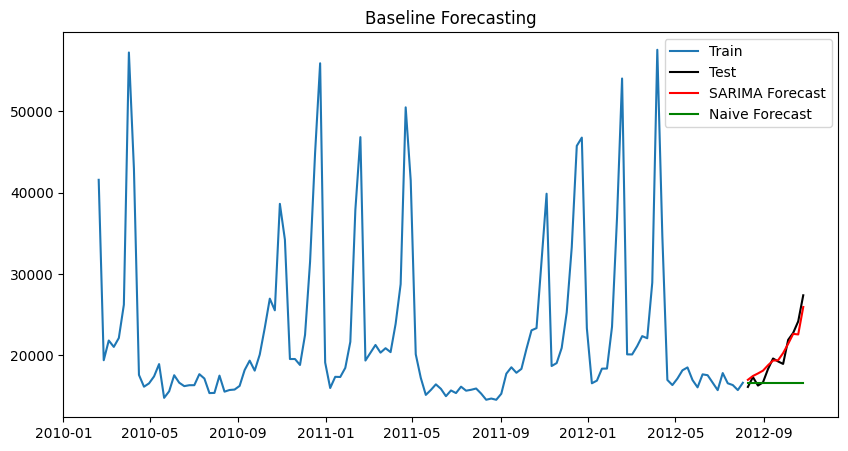

In [274]:
# Prepare data for Naive Forecast & Sarima
y_train = train["Weekly_Sales_clipped"]
y_test = test["Weekly_Sales_clipped"]

# --- Naive Forecast (last observed value) ---
naive_forecast = np.repeat(y_train.iloc[-1], len(y_test))

# --- SARIMA Model ---
sarima_model = sm.tsa.statespace.SARIMAX(
    y_train,
    order=(1,1,1),              # ARIMA(p,d,q)
    seasonal_order=(1,1,1,52),  # SARIMA(P,D,Q,s) with yearly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarima_forecast = sarima_model.forecast(steps=len(y_test))

nv_results = evaluate(y_test, naive_forecast, "Naive Baseline")
sarima_results = evaluate(y_test, sarima_forecast, "SARIMA")

# Plot 
plt.figure(figsize=(10,5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Test", color="black")
plt.plot(y_test.index, sarima_forecast, label="SARIMA Forecast", color="red")
plt.plot(y_test.index, naive_forecast, label="Naive Forecast", color="green")
plt.title("Baseline Forecasting")
plt.legend()
plt.show()

##### ***Prophet***

01:35:43 - cmdstanpy - INFO - Chain [1] start processing
01:35:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet -> MAE: 1751.34, RMSE: 2338.01, wMAPE: 8.80%, SMAPE: 8.22%


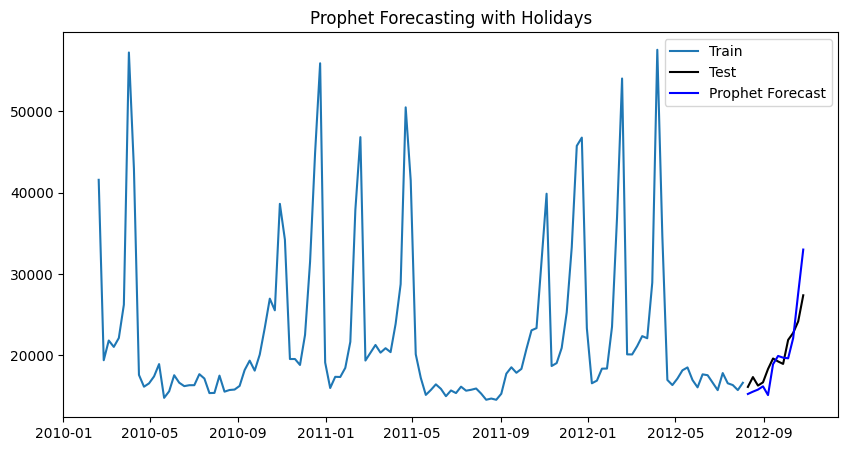

In [275]:
# Prepare data for Prophet
prophet_train = train.reset_index()[["Date", "Weekly_Sales_clipped"]]
prophet_train.columns = ["ds", "y"]

prophet_test = test.reset_index()[["Date", "Weekly_Sales_clipped"]]
prophet_test.columns = ["ds", "y"]

# Define holiday dataframe from IsHoliday flag
holidays = fe_data[fe_data["IsHoliday"] == 1][["Date"]].drop_duplicates()
holidays = holidays.rename(columns={"Date": "ds"})
holidays["holiday"] = "US_Holiday"

# Fit Prophet
prophet_model = Prophet(weekly_seasonality=True, yearly_seasonality=True, holidays=holidays)
prophet_model.fit(prophet_train)

# Forecast
future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq="W-FRI")
forecast = prophet_model.predict(future)

# Extract forecasted values for test period
prophet_forecast = forecast.set_index("ds").loc[prophet_test["ds"], "yhat"]

# Evaluate
prophet_results = evaluate(prophet_test["y"].values, prophet_forecast.values, "Prophet")

# Plot
plt.figure(figsize=(10,5))
plt.plot(train.index, train["Weekly_Sales_clipped"], label="Train")
plt.plot(test.index, test["Weekly_Sales_clipped"], label="Test", color="black")
plt.plot(prophet_test["ds"], prophet_forecast, label="Prophet Forecast", color="blue")
plt.title("Prophet Forecasting with Holidays")
plt.legend()
plt.show()

#### ***Tree Based Models***

##### ***Global LightGBM Model***

In [276]:
# Feature selection
FEATURES = [
    "Sales_Lag1","Sales_Lag2","Sales_MA3","Sales_MA6",
    "Total_MarkDown","Has_MarkDown",
    "IsHoliday","IsHoliday_NextWeek",
    "CPI","Unemployment","Fuel_Price","Temperature",
    "Size","Sales_per_sqft",
    "WeekOfYear","Month","Quarter","DayOfWeek",
    "Type","Store","Dept"
]
TARGET = "Weekly_Sales_clipped"

# Train/test split (last 12 weeks = test)
H = 12
cutoff = fe_data["Date"].max() - pd.Timedelta(weeks=H)
train_all = fe_data[fe_data["Date"] <= cutoff].copy()
test_all  = fe_data[fe_data["Date"] >  cutoff].copy()

print("Train:", train_all["Date"].min(), "to", train_all["Date"].max())
print("Test :", test_all["Date"].min(), "to", test_all["Date"].max())

Train: 2010-02-19 00:00:00 to 2012-08-03 00:00:00
Test : 2012-08-10 00:00:00 to 2012-10-26 00:00:00


In [277]:
# Encode categoricals
X_train = train_all[FEATURES].copy()
y_train = train_all[TARGET].copy()
X_test  = test_all[FEATURES].copy()
y_test  = test_all[TARGET].copy()

cat_cols = ["Type","Store","Dept"]
encoders = {}

for c in cat_cols:
    le = LabelEncoder()
    all_vals = pd.concat([X_train[c].astype(str), X_test[c].astype(str)])
    le.fit(all_vals)  # fit on both train + test
    X_train[c] = le.transform(X_train[c].astype(str))
    X_test[c]  = le.transform(X_test[c].astype(str))
    encoders[c] = le

In [278]:
# LightGBM training
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
lgb_eval  = lgb.Dataset(X_test, label=y_test, reference=lgb_train, categorical_feature=cat_cols)

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "min_data_in_leaf": 20,
    "verbosity": -1,
    "seed": 42
}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=["train","valid"],
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)]
    )

# Evaluation
pred = model.predict(X_test, num_iteration=model.best_iteration)
lgbm_results = evaluate(y_test, pred, "Global LightGBM")

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2051.11	valid's rmse: 1411.4
[200]	train's rmse: 1500.96	valid's rmse: 1045.46
[300]	train's rmse: 1246.18	valid's rmse: 884.145
[400]	train's rmse: 1088.79	valid's rmse: 796.528
[500]	train's rmse: 975.547	valid's rmse: 748.307
[600]	train's rmse: 890.698	valid's rmse: 717.239
[700]	train's rmse: 823.516	valid's rmse: 691.731
[800]	train's rmse: 767.821	valid's rmse: 672.015
[900]	train's rmse: 722.089	valid's rmse: 659.119
[1000]	train's rmse: 685.069	valid's rmse: 649.426
[1100]	train's rmse: 652.559	valid's rmse: 643.751
[1200]	train's rmse: 625.762	valid's rmse: 638.514
[1300]	train's rmse: 600.395	valid's rmse: 635.715
[1400]	train's rmse: 578.737	valid's rmse: 630.67
Early stopping, best iteration is:
[1441]	train's rmse: 568.912	valid's rmse: 628.964
Global LightGBM -> MAE: 222.10, RMSE: 628.96, wMAPE: 1.42%, SMAPE: 9.08%


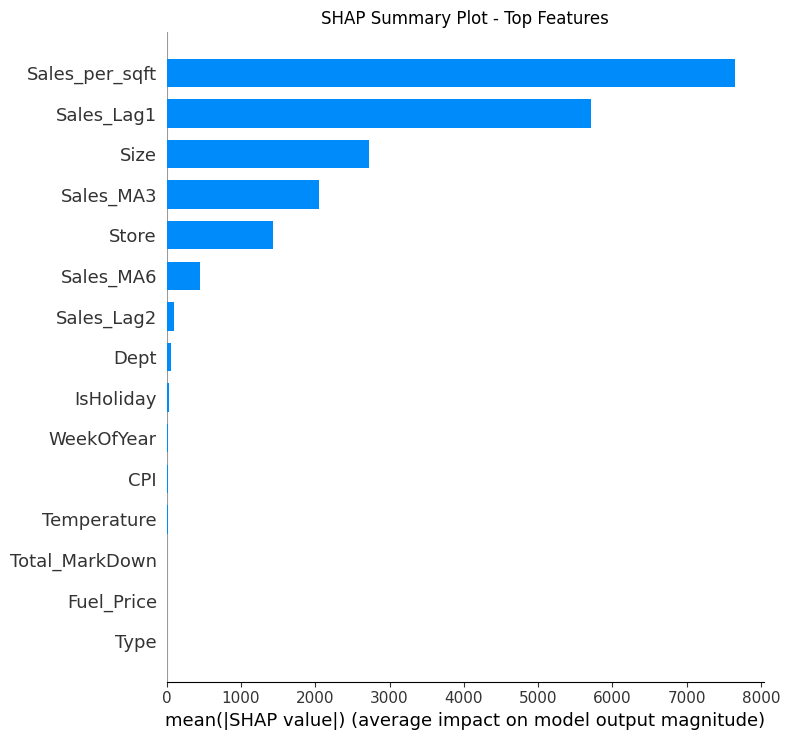

<Figure size 640x480 with 0 Axes>

In [279]:
# SHAP Analysis
explainer = shap.TreeExplainer(model) # Explainer
shap_values = explainer.shap_values(X_test)

# Summary Plot - Global Feature Importance
plt.figure(figsize=(15, 6))
plt.title("SHAP Summary Plot - Top Features")
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)
plt.tight_layout()
plt.show()

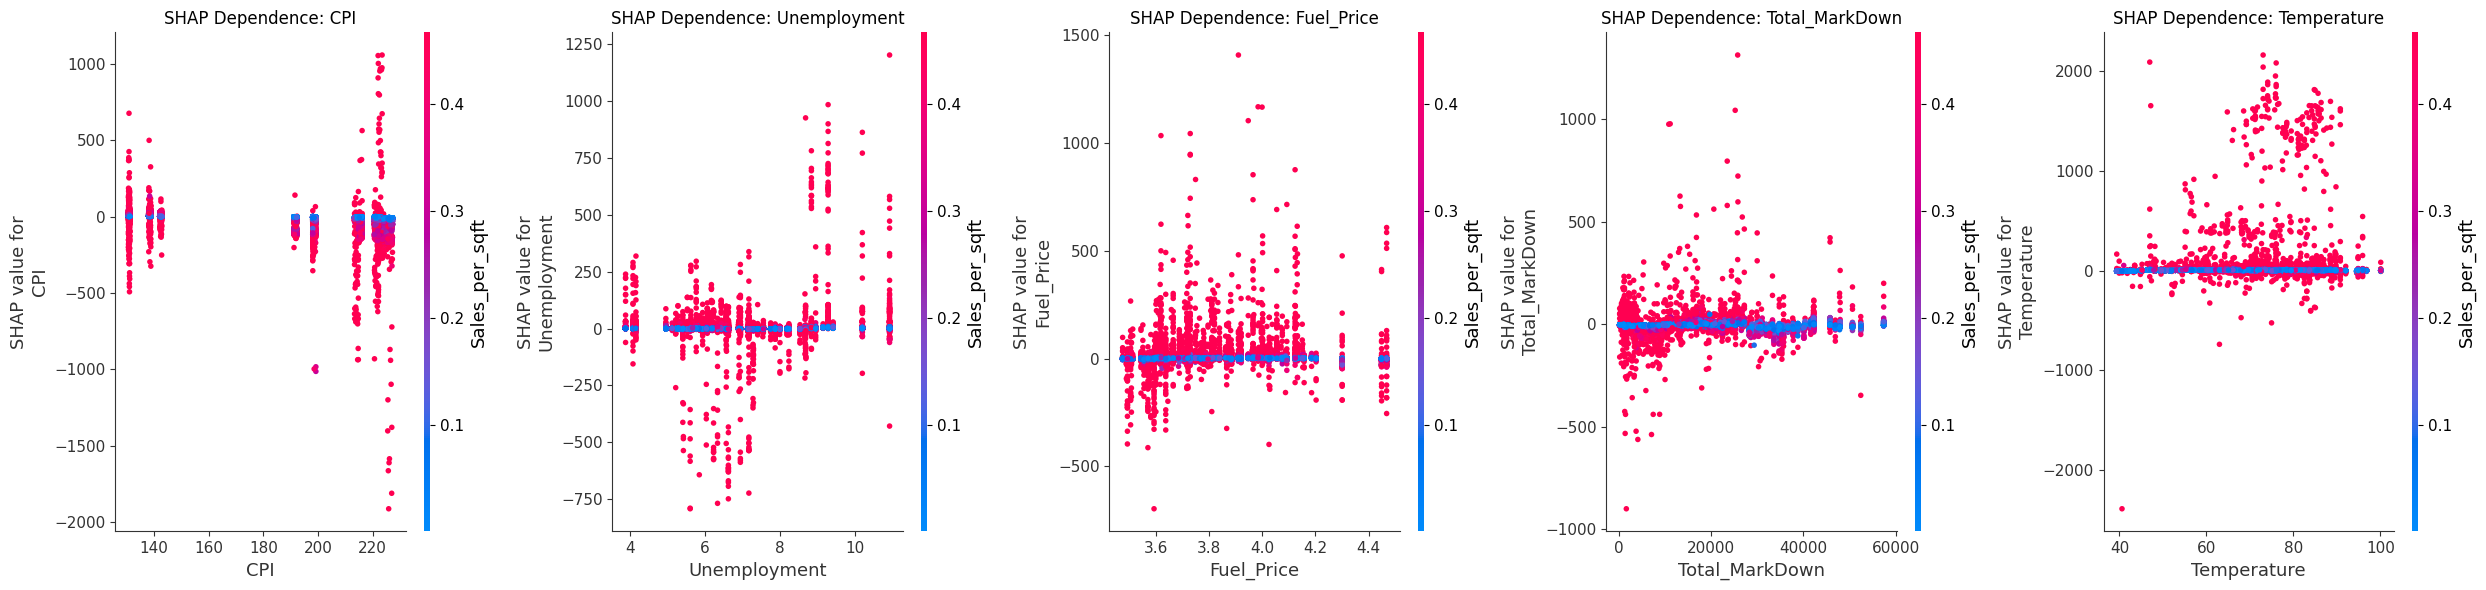

In [280]:
# Focused Features
focus_features = ["CPI","Unemployment","Fuel_Price","Total_MarkDown","Temperature"]

fig, axes = plt.subplots(1, 5, figsize=(25, 6))
axes = axes.flatten()

for i, f in enumerate(focus_features):
    if f in X_test.columns:
        shap.dependence_plot(
            f, shap_values, X_test,
            show=False, ax=axes[i]
        )
        axes[i].set_title(f"SHAP Dependence: {f}")

plt.tight_layout()
plt.show()

##### ***Random Forest***

In [281]:
# Random Forest 
rf = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_results = evaluate(y_test, rf_pred, "Random Forest")

Random Forest -> MAE: 215.12, RMSE: 710.30, wMAPE: 1.38%, SMAPE: 2.95%


##### ***XGBoost***

In [282]:
# XGBoost 
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

xgb_pred = xgb_model.predict(X_test)
xgb_results = evaluate(y_test, xgb_pred, "XGBoost")

XGBoost -> MAE: 131.27, RMSE: 339.34, wMAPE: 0.84%, SMAPE: 6.03%


#### ***Deep Learning***

##### ***LSTM***

In [283]:
# LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])), 
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
lstm.compile(optimizer="adam", loss="mse")
lstm.fit(X_train_lstm, y_train, epochs=20, batch_size=32,
         verbose=1, validation_data=(X_test_lstm, y_test))

lstm_pred = lstm.predict(X_test_lstm).ravel()
lstm_results = evaluate(y_test, lstm_pred, "LSTM")

Epoch 1/20
11857/11857 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 771813312.0000 - val_loss: 705272704.0000
Epoch 2/20
11857/11857 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 745445568.0000 - val_loss: 688708864.0000
Epoch 3/20
11857/11857 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 731443328.0000 - val_loss: 672838784.0000
Epoch 4/20
11857/11857 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 723389376.0000 - val_loss: 657644672.0000
Epoch 5/20
11857/11857 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 708825408.0000 - val_loss: 643154944.0000
Epoch 6/20
11857/11857 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 689730048.0000 - val_loss: 629307328.0000
Epoch 7/20
11857/11857 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 685688064.0000 - val_loss: 616168192.0000
Epoch 8/20
11857/11857 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 657549568.0000 - val_loss: 603689152.0000
Epoch 9/20
11857/11857 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 656286336.0000 - val_loss: 591881984.0000
Epoch 10/20
11857/11857 ━━━━━━━━━━━━━

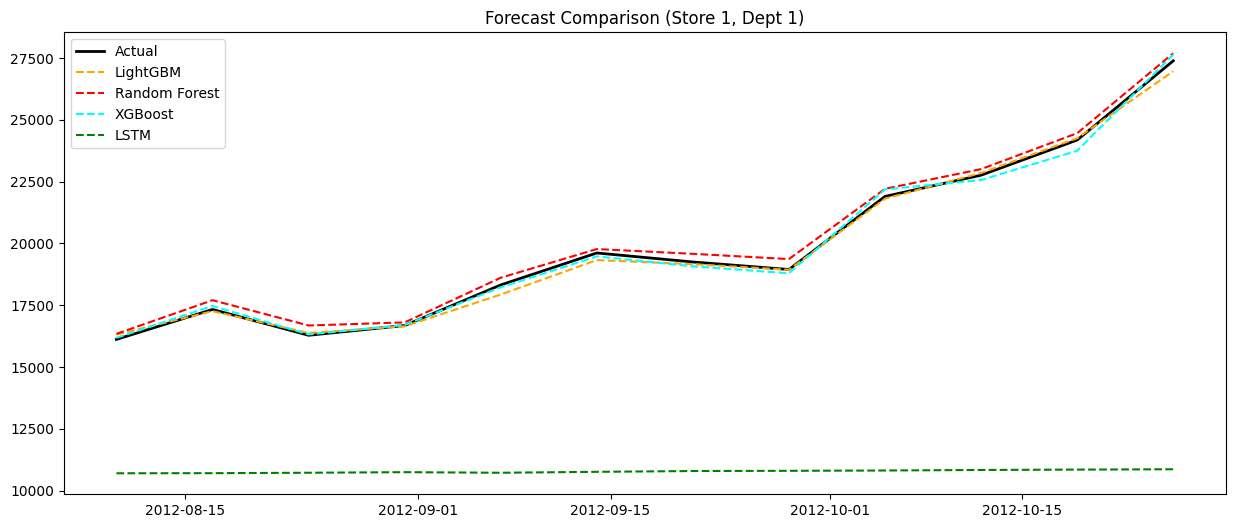

In [284]:
# Plot one Store–Dept group at a time
store, dept = 1, 1
mask = (test_all["Store"] == store) & (test_all["Dept"] == dept)

plt.figure(figsize=(15,6))
plt.plot(test_all.loc[mask, "Date"], y_test[mask], label="Actual", color="black", linewidth=2)
plt.plot(test_all.loc[mask, "Date"], pred[mask], label="LightGBM", color="orange", linestyle="--")
plt.plot(test_all.loc[mask, "Date"], rf_pred[mask], label="Random Forest", color="red", linestyle="--")
plt.plot(test_all.loc[mask, "Date"], xgb_pred[mask], label="XGBoost", color="cyan", linestyle="--")
plt.plot(test_all.loc[mask, "Date"], lstm_pred[mask], label="LSTM", color="green", linestyle="--")
plt.title(f"Forecast Comparison (Store {store}, Dept {dept})")
plt.legend()
plt.show()

In [285]:
# Compare
results = pd.DataFrame([
    {"Model": "Naive", **nv_results},
    {"Model": "SARIMA", **sarima_results},
    {"Model": "Prophet", **prophet_results},
    {"Model": "LightGBM", **lgbm_results},
    {"Model": "Random Forest", **rf_results},
    {"Model": "XGBoost", **xgb_results},
    {"Model": "LSTM", **lstm_results},
])

print("Compare All Results:\n")
print(results)

Compare All Results:

           Model           mae          rmse      wmape      smape
0          Naive   3413.383333   4684.671745  17.152700  17.328501
1         SARIMA    815.238130   1002.622377   4.096679   4.120348
2        Prophet   1751.344145   2338.011375   8.800735   8.217306
3       LightGBM    222.101429    628.963704   1.424123   9.077632
4  Random Forest    215.116860    710.303336   1.379337   2.952063
5        XGBoost    131.265257    339.342310   0.841678   6.034389
6           LSTM  10123.726297  21605.285953  64.913714  74.388950


##### **Since we've already run all models once globally, we do not need to run all models per group. We can pick the best global model and scale it across all Store × Dept groups.**
***Insights***
- XGBoost has the lowest MAE, RMSE, and wMAPE → best overall accuracy.
- Random Forest is close but has slightly higher RMSE.
- LightGBM is decent but not as good as XGBoost here.
- Naive/SARIMA/Prophet are far weaker for global forecasting.
- LSTM failed badly (likely underfit/misaligned input structure).

***Best Choice → XGBoost* It clearly outperforms others on all error metrics (especially RMSE & wMAPE).**

#### ***Scaling XGBoost across Store × Dept***

In [286]:
# --- Save directory for models ---
MODEL_DIR = "Models"
os.makedirs(MODEL_DIR, exist_ok=True)

# --- Features & Target ---
FEATURES = [
    "Sales_Lag1","Sales_Lag2","Sales_MA3","Sales_MA6",
    "Total_MarkDown","Has_MarkDown",
    "IsHoliday","IsHoliday_NextWeek",
    "CPI","Unemployment","Fuel_Price","Temperature",
    "Size","Sales_per_sqft",
    "WeekOfYear","Month","Quarter","DayOfWeek",
    "Type"   
]
TARGET = "Weekly_Sales_clipped"

# --- Encode categorical Type globally ---
le = LabelEncoder()
fe_data["Type"] = le.fit_transform(fe_data["Type"].astype(str))

print("Prepared features:", FEATURES)

Prepared features: ['Sales_Lag1', 'Sales_Lag2', 'Sales_MA3', 'Sales_MA6', 'Total_MarkDown', 'Has_MarkDown', 'IsHoliday', 'IsHoliday_NextWeek', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature', 'Size', 'Sales_per_sqft', 'WeekOfYear', 'Month', 'Quarter', 'DayOfWeek', 'Type']


In [287]:
# Store results
results = {}
forecasts = {}

# Loop per Store × Dept group
for (store, dept), g in fe_data.groupby(["Store","Dept"], observed=True):
    # Sort by date
    g = g.sort_values("Date").copy()
    
    # Train-test split (last 12 weeks = test)
    H = 12
    cutoff = g["Date"].max() - pd.Timedelta(weeks=H)
    train, test = g[g["Date"] <= cutoff], g[g["Date"] > cutoff]
    
    if len(train) < 20 or len(test) < 1:  # skip very small groups
        continue
    
    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test   = test[FEATURES], test[TARGET]
    
    # --- Train XGBoost ---
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    preds = model.predict(X_test) 
    
    # --- Evaluate ---
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = np.mean(np.abs((y_test - preds) / np.where(y_test==0,1e-8,y_test))) * 100
    
    results[(store, dept)] = {"mae": mae, "rmse": rmse, "mape": mape}
    forecasts[(store, dept)] = {"test_dates": test["Date"], "y_test": y_test, "preds": preds}

    # --- Save model ---
    model_path = os.path.join(MODEL_DIR, f"store{store}_dept{dept}.pkl")
    joblib.dump(model, model_path)

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df.index.names = ["Store","Dept"]
results_df.reset_index(inplace=True)

print("Evaluation Results (head):")
print(results_df.head())

Evaluation Results (head):
   Store  Dept         mae         rmse      mape
0      1     1  330.387946   517.442944  1.530078
1      1     2   83.159596   132.300542  0.185245
2      1     3  960.691364  1494.305982  3.526787
3      1     4   66.622344    77.481124  0.181588
4      1     5  862.220400  1059.318463  3.923129


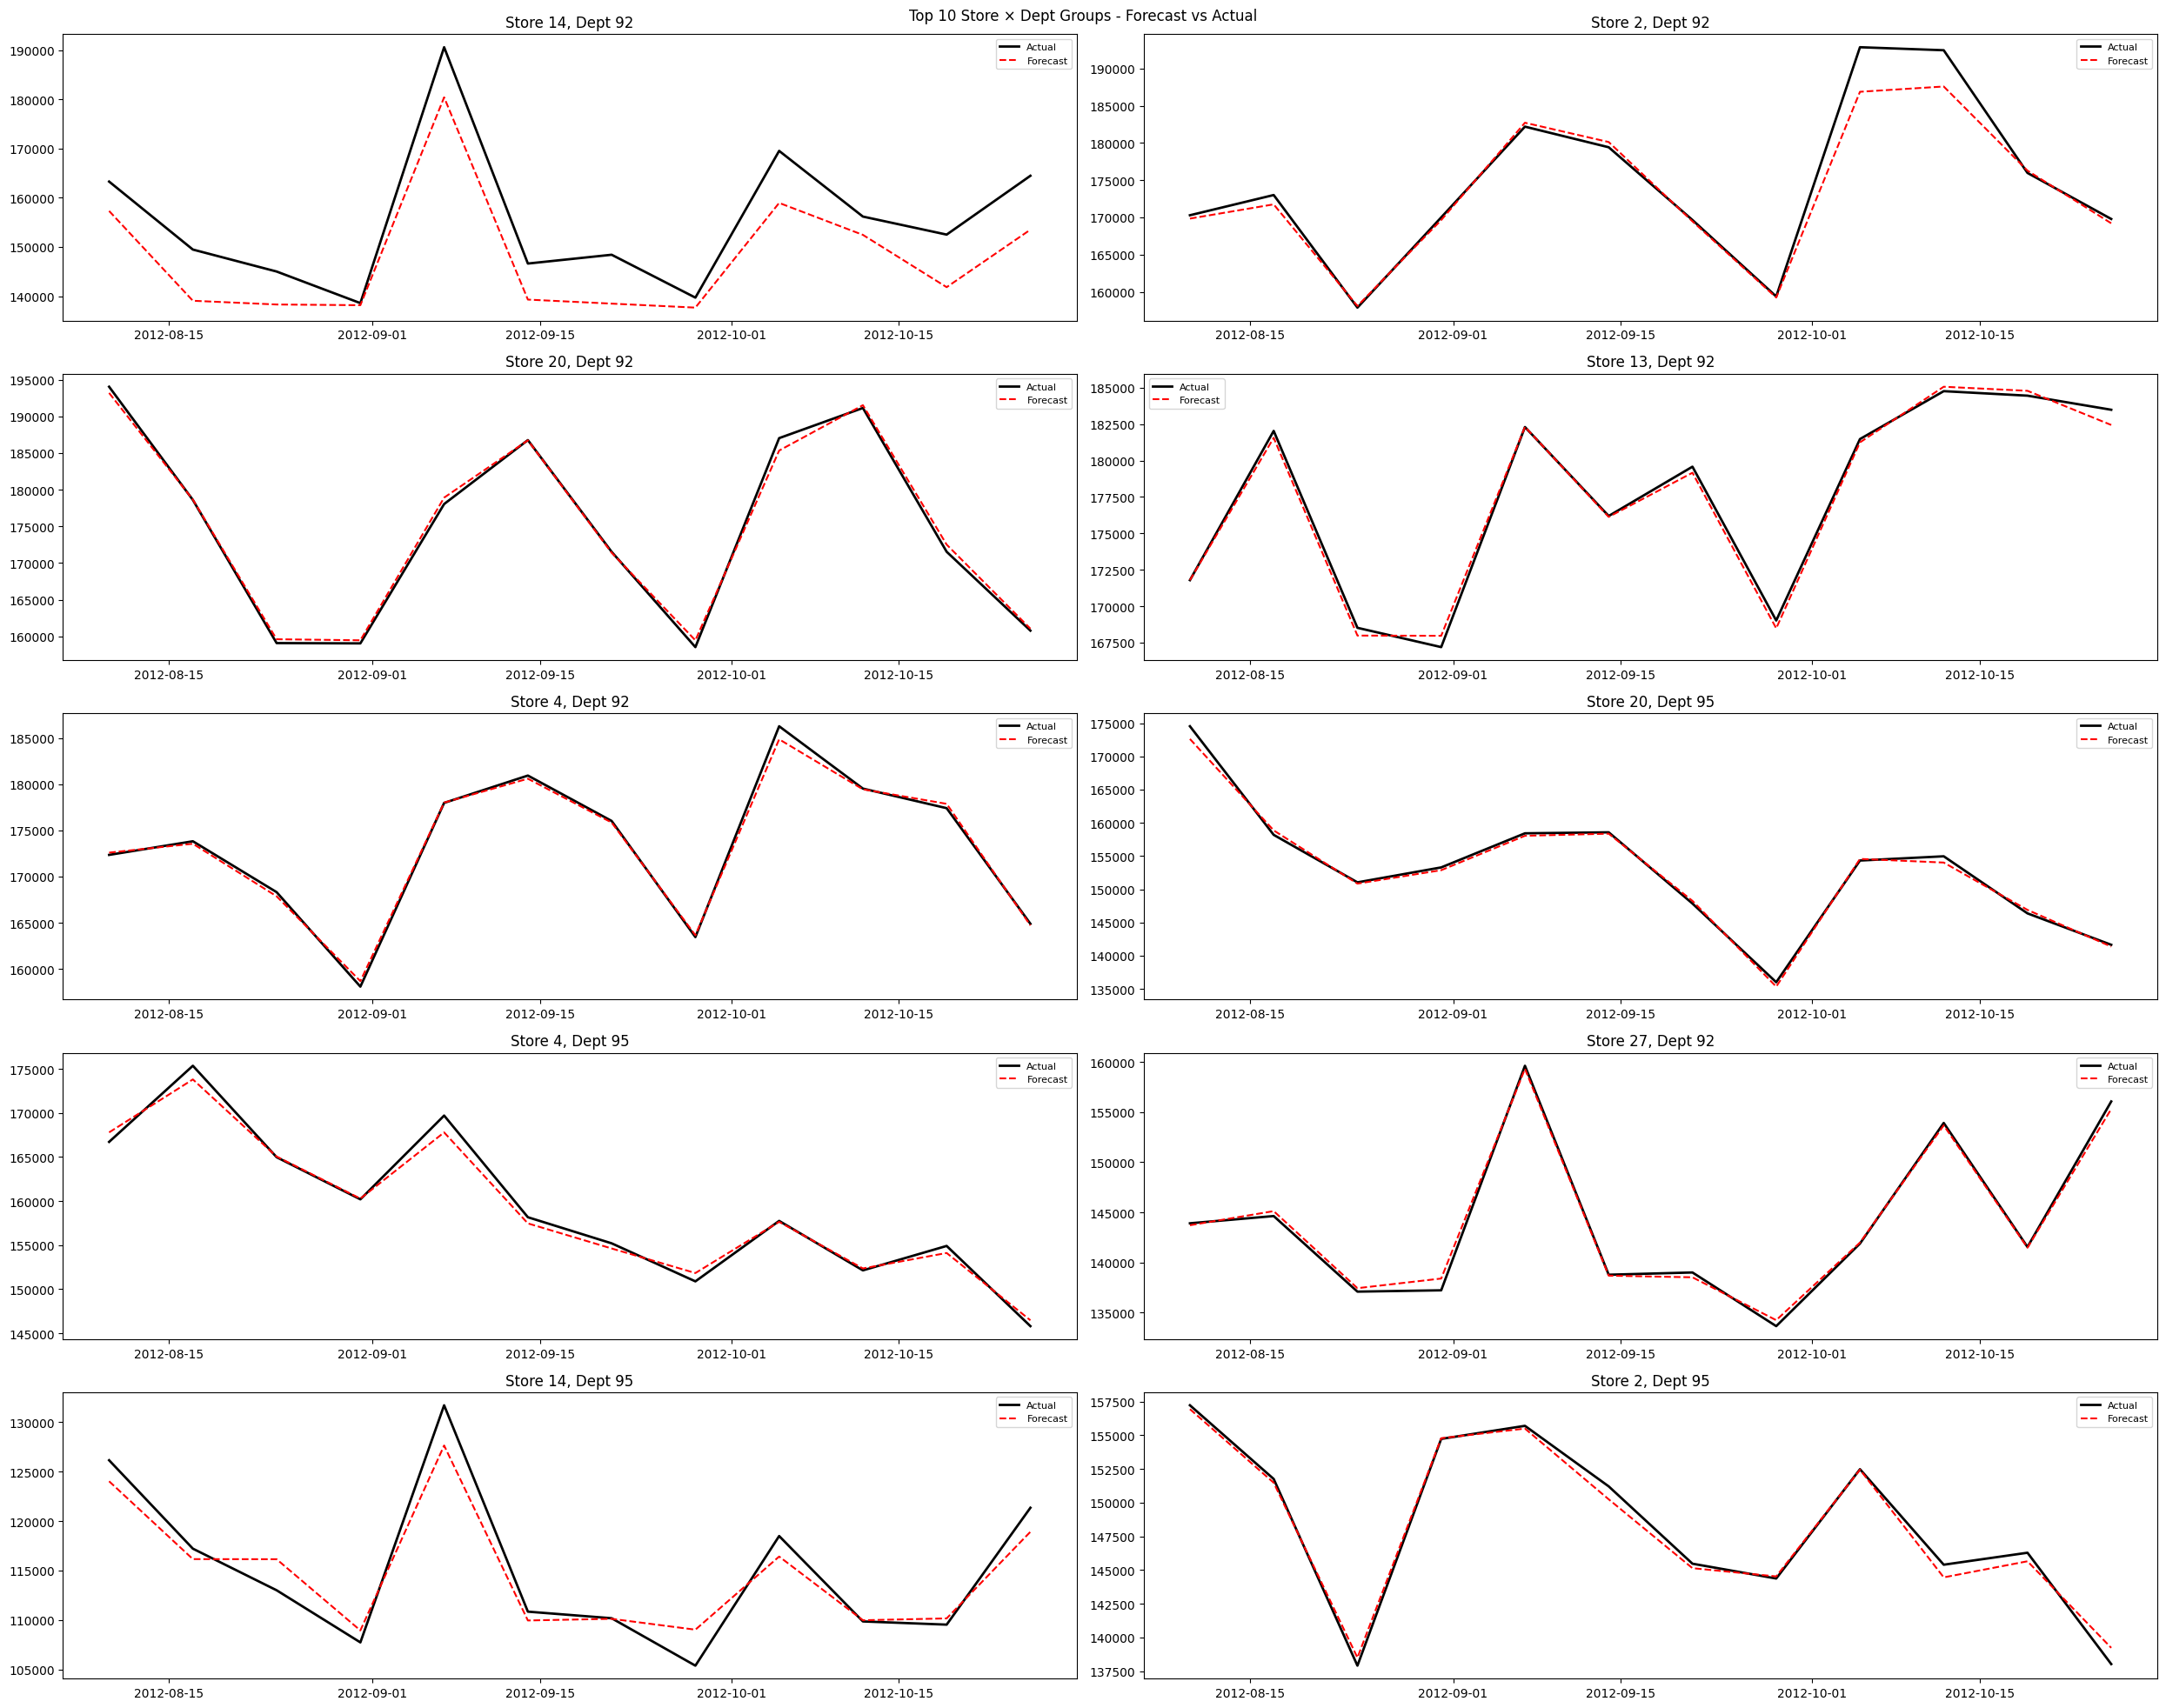

In [288]:
# Visualize predictions 
top_groups = (fe_data.groupby(["Store","Dept"], observed=True)["Weekly_Sales_clipped"].sum().nlargest(10).index) # Pick top 10 groups by total sales

fig, axes = plt.subplots(5, 2, figsize=(25, 20), sharex=False)
axes = axes.flatten()

for idx, (store, dept) in enumerate(top_groups):
    if (store, dept) not in forecasts:
        continue
    
    fcast = forecasts[(store, dept)]
    
    ax = axes[idx]
    ax.plot(fcast["test_dates"], fcast["y_test"], label="Actual", color="black", linewidth=2)
    ax.plot(fcast["test_dates"], fcast["preds"], label="Forecast", color="red", linestyle="--")
    
    ax.set_title(f"Store {store}, Dept {dept}", fontsize=12)
    ax.legend(fontsize=8)

plt.suptitle("Top 10 Store × Dept Groups - Forecast vs Actual")
plt.tight_layout()
plt.show()

#### ***Forecast for Future 4 Weeks***

In [289]:
future_forecasts = {}

for (store, dept), g in fe_data.groupby(["Store","Dept"], observed=True):
    g = g.sort_values("Date").copy()

    # Load model if exists
    model_path = os.path.join(MODEL_DIR, f"store{store}_dept{dept}.pkl")
    if not os.path.exists(model_path):
        continue
    
    model = joblib.load(model_path)

    # Start from the last available week
    last_date = g["Date"].max()
    X_last = g[FEATURES].iloc[-1:].copy()

    preds_future = []
    future_dates = []

    for i in range(1, 5):  # forecast 4 weeks ahead
        future_date = last_date + pd.Timedelta(weeks=i)
        future_dates.append(future_date)

        # Predict
        y_pred = model.predict(X_last)[0]
        preds_future.append(y_pred)

        # Update lags & moving averages for next iteration
        new_row = X_last.copy()
        new_row["Sales_Lag1"] = y_pred
        new_row["Sales_Lag2"] = X_last["Sales_Lag1"].values[0]
        new_row["Sales_MA3"] = (X_last["Sales_Lag1"].values[0] + 
                                X_last["Sales_Lag2"].values[0] + y_pred) / 3
        new_row["Sales_MA6"] = ((X_last["Sales_Lag1"].values[0] + 
                                 X_last["Sales_Lag2"].values[0] + y_pred) / 3)  # simple rolling update

        # Update time features
        new_row["WeekOfYear"] = future_date.isocalendar().week
        new_row["Month"] = future_date.month
        new_row["Quarter"] = (future_date.month - 1)//3 + 1
        new_row["DayOfWeek"] = future_date.weekday()

        X_last = new_row

    # Save forecasts
    future_forecasts[(store, dept)] = {"future_dates": future_dates, "preds": preds_future}

In [292]:
# Convert future_forecasts dict → DataFrame
all_preds = []

for (store, dept), data in future_forecasts.items():
    temp_df = pd.DataFrame({
        "Store": store,
        "Dept": dept,
        "Date": data["future_dates"],
        "Predicted_Sales": data["preds"]
    })
    all_preds.append(temp_df)

future_forecasts_df = pd.concat(all_preds, ignore_index=True)

# Preview
print(future_forecasts_df.shape)
display(future_forecasts_df.head())

# Save to CSV (optional)
future_forecasts_df.to_csv(r"C:\Users\spand\Projects\LABMENTIX_PROJECTS\Retail_Analytics_Store_Optimization\Data\Processed\future_forecasts_4weeks.csv", index=False)

(12228, 4)


Store  Dept       Date  Predicted_Sales
0      1     1 2012-11-02     27187.609375
1      1     1 2012-11-09     31299.742188
2      1     1 2012-11-16     30401.896484
3      1     1 2012-11-23     29175.681641
4      1     2 2012-11-02     43012.472656